## PROBLEM STATEMENT

#### DOMAIN

Health Care


#### CONTEXT

Computer vision can be used in health care for identifying diseases. In Pneumonia detection we need to detect Inflammation of  the  lungs.  In  this  challenge,  you’re  required  to  build  an  algorithm  to  detect  a  visual  signal  for  pneumonia  in  medical images. Specifically, your algorithm needs to automatically locate lung opacities on chest radiographs.


#### DATA DESCRIPTION

In the dataset, some of the features are labeled “Not Normal No Lung Opacity”. This extra third class indicates that while pneumonia was determined not to be present, there was nonetheless some type of abnormality on the image and oftentimes this finding may mimic the appearance of true pneumonia.

Dicom original images:
- Medical images are stored in a special format called DICOM files (*.dcm). They contain a combination of header metadata as well as underlying raw image arrays for pixel data.
- Dataset has been attached along with this project. Please use the same for this capstone project.
- Original  link  to  the  dataset  : https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/data
- Acknowledgements: https://www.kaggle.com/c/rsna-pneumonia-detection-challenge/overview/acknowledgements.•PROJECT OBJECTIVE: Design a DL based algorithm for detecting pneumonia

In [7]:
pip install pydicom
pip install wandb
pip install ultralytics


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import required libraries

# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.utils import Sequence
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
from sklearn.metrics import confusion_matrix, classification_report
from ultralytics import YOLO
import wandb

# Image Processing Libraries
import cv2
from PIL import Image

# Data Handling Libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import random

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
import matplotlib.image as mpimg
import matplotlib.patches as patches

# File and Operating System Libraries
import os
import pydicom as dcm
from glob import glob
from pathlib import Path
import shutil
import itertools
import pickle

np.random.seed(1337)

# Warnings Management
import warnings
warnings.filterwarnings('ignore')

#### PROJECT TASK: [ Score: 100 points]
#### 1. Milestone 1:[ Score: 40 points]
##### Input: Context and Dataset

#### Process
##### Step 1: Import the data. [ 3 points ]

In [4]:
# Mount Google Drive to '/content/drive' to read dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Read and Load the dataset**

In [ ]:
train_metadata = pd.read_csv('/content/drive/MyDrive/Dataset/stage_2_train_labels.csv')

In [ ]:
print('Columns, Non-Null Counts and Datatypes in the Training set:\n')
train_metadata.info();

Columns, Non-Null Counts and Datatypes in the Training set:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB


In [ ]:
print(f'train_metadata has {train_metadata.shape[0]} rows and {train_metadata.shape[1]} columns')

train_metadata has 30227 rows and 6 columns


In [ ]:
print('First five rows of train_metadata:\n')
print(train_metadata.head(5))

First five rows of train_metadata:

                              patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1


In [ ]:
print(f'train_metadata has {train_metadata.shape[0]} rows and {train_metadata.shape[1]} columns')
print(f'train_metadata has {train_metadata["patientId"].nunique()} unique patientIDs')
print(f'train_metadata has {len(train_metadata) - train_metadata["patientId"].nunique()} duplicate patientIDs')

train_metadata has 30227 rows and 6 columns
train_metadata has 26684 unique patientIDs
train_metadata has 3543 duplicate patientIDs


In [ ]:
train_class_labels = pd.read_csv('/content/drive/MyDrive/Dataset/stage_2_detailed_class_info.csv')

In [ ]:
print('Columns, Non-Null Counts and Datatypes in the train_class_labels:\n')
train_class_labels.info();

Columns, Non-Null Counts and Datatypes in the train_class_labels:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   patientId  30227 non-null  object
 1   class      30227 non-null  object
dtypes: object(2)
memory usage: 472.4+ KB


In [ ]:
print(f'train_class_labels has {train_class_labels.shape[0]} rows and {train_class_labels.shape[1]} columns')

train_class_labels has 30227 rows and 2 columns


In [ ]:
print('First five rows of train_class_labels:\n')
print(train_class_labels.head(5))

First five rows of train_class_labels:

                              patientId                         class
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6  No Lung Opacity / Not Normal
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd  No Lung Opacity / Not Normal
2  00322d4d-1c29-4943-afc9-b6754be640eb  No Lung Opacity / Not Normal
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5                        Normal
4  00436515-870c-4b36-a041-de91049b9ab4                  Lung Opacity


**Data Cleaning**

In [ ]:
print(f'train_class_labels has {train_class_labels["patientId"].nunique()} unique patientIDs')
print(f'train_class_labels has {len(train_class_labels) - train_class_labels["patientId"].nunique()} duplicate patientIDs')

train_class_labels has 26684 unique patientIDs
train_class_labels has 3543 duplicate patientIDs


In [ ]:
print('Number of null values in train_class_labels: {}'.format(train_class_labels['class'].isnull().sum()))

Number of null values in train_class_labels: 0


In [ ]:
print('Number of null values in bounding boxes columns: {}'.format(train_metadata[['x', 'y', 'width', 'height']].isnull().sum().to_dict()))
print('Value counts in the Target column: {}'.format(train_metadata['Target'].value_counts().to_dict()))

Number of null values in bounding boxes columns: {'x': 20672, 'y': 20672, 'width': 20672, 'height': 20672}
Value counts in the Target column: {0: 20672, 1: 9555}


- There are 20672 null values in the bounding box columns which corresponds to 0 in the Target column.
- There are 30227 rows and 26684 unique patientIDs in train_metadata and train_class_labels.

##### Step 2: Map training and testing images to its classes. [ 4 points ]

In [ ]:
# Create a dictionary mapping patient IDs to their respective class labels
image_classes = dict(zip(train_class_labels['patientId'], train_class_labels['class']))

# Display a few sample mappings for verification
print("Mapping of training and testing images to their corresponding classes:\n")
print("Sample mappings:")

# Display the first 5 mappings as an example
sample_mappings = list(image_classes.items())[:5]
for patient_id, class_label in sample_mappings:
    print(f"Patient ID: {patient_id} => Class: {class_label}")

Mapping of training and testing images to their corresponding classes:

Sample mappings:
Patient ID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6 => Class: No Lung Opacity / Not Normal
Patient ID: 00313ee0-9eaa-42f4-b0ab-c148ed3241cd => Class: No Lung Opacity / Not Normal
Patient ID: 00322d4d-1c29-4943-afc9-b6754be640eb => Class: No Lung Opacity / Not Normal
Patient ID: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 => Class: Normal
Patient ID: 00436515-870c-4b36-a041-de91049b9ab4 => Class: Lung Opacity


##### Step 3: Map training and testing images to its annotations. [ 4 points ]

In [ ]:
# Create a dictionary to store the bounding box annotations for each patient ID

image_annotations = {}

# Iterate through each row in the train_labels DataFrame
for _, row in train_metadata.iterrows():
    patient_id = row['patientId']
    bbox = (row['x'], row['y'], row['width'], row['height'])

    # Add the bounding box to the list for the respective patient ID
    if patient_id not in image_annotations:
        image_annotations[patient_id] = []
    image_annotations[patient_id].append(bbox)

# Inform the user that the mapping process is complete
print("Training and testing images successfully mapped to their annotations.")

# Display sample annotations for verification
print("\nSample annotations:")
for i, (patient_id, bboxes) in enumerate(image_annotations.items()):
    print(f"Patient ID: {patient_id} => Bounding Boxes: {bboxes}")
    if i >= 7:  # Show first 8 mappings as a sample (change to 7 for 8 total)
        break


Training and testing images successfully mapped to their annotations.

Sample annotations:
Patient ID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6 => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 00313ee0-9eaa-42f4-b0ab-c148ed3241cd => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 00322d4d-1c29-4943-afc9-b6754be640eb => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 003d8fa0-6bf1-40ed-b54c-ac657f8495c5 => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 00436515-870c-4b36-a041-de91049b9ab4 => Bounding Boxes: [(264.0, 152.0, 213.0, 379.0), (562.0, 152.0, 256.0, 453.0)]
Patient ID: 00569f44-917d-4c86-a842-81832af98c30 => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 006cec2e-6ce2-4549-bffa-eadfcd1e9970 => Bounding Boxes: [(nan, nan, nan, nan)]
Patient ID: 00704310-78a8-4b38-8475-49f4573b2dbb => Bounding Boxes: [(323.0, 577.0, 160.0, 104.0), (695.0, 575.0, 162.0, 137.0)]


##### Step 4: Preprocessing and Visualisation of different classes [4 Points]

In [ ]:
# Count the number of cases with and without pneumonia
pneumonia_count = train_metadata[train_metadata.Target == 1].shape[0]
no_pneumonia_count = train_metadata[train_metadata.Target == 0].shape[0]

# Calculate percentages
pneumonia_percentage = round((pneumonia_count / train_metadata.shape[0]) * 100, 0)
no_pneumonia_percentage = round((no_pneumonia_count / train_metadata.shape[0]) * 100, 0)

# Print the counts and percentages
print(f'No of entries which has Pneumonia: {pneumonia_count} ~ {pneumonia_percentage}%')
print(f'No of entries which don\'t have Pneumonia: {no_pneumonia_count} ~ {no_pneumonia_percentage}%')

No of entries which has Pneumonia: 9555 ~ 32.0%
No of entries which don't have Pneumonia: 20672 ~ 68.0%


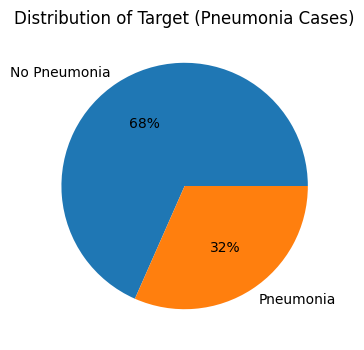

In [ ]:
# Plot a pie chart for visualization
_ = train_metadata['Target'].value_counts().plot(
    kind='pie',
    autopct='%.0f%%',
    labels=['No Pneumonia', 'Pneumonia'],
    figsize=(4, 4)
)
plt.title("Distribution of Target (Pneumonia Cases)")
plt.ylabel("")
plt.show()

The pie chart above clearly shows that out of the 30,227 entries in the dataset, 20,672 (68%) do not have pneumonia, while 9,555 (32%) do.

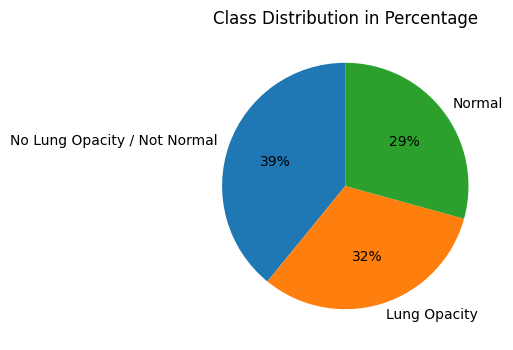

In [ ]:
# Calculate class counts and percentages
class_counts = train_class_labels['class'].value_counts()
class_percentages = (class_counts / class_counts.sum()) * 100

# Plot the pie chart
fig, ax = plt.subplots(figsize=(4, 4))
ax.pie(class_percentages, labels=class_counts.index, autopct='%.0f%%', startangle=90)

# Set title
ax.set_title('Class Distribution in Percentage')

plt.show()

In [ ]:
#Check whether each patientID has only one type of class or not
train_class_labels.groupby(['patientId'])['class'].nunique().max()

1

Each patientID has only one type of class

In [ ]:
# Calculate the number of bounding boxes per unique patient ID
bboxes = train_metadata.groupby('patientId').size().reset_index(name='number_of_boxes')

# Merge the bounding box count with the original train metadata
train_labels = train_metadata.merge(bboxes, on='patientId', how='left')

# Display the number of patient IDs associated with each bounding box count
bboxes_summary = (bboxes.groupby('number_of_boxes')
                  .size()
                  .reset_index(name='count')  # Rename the count column to 'count'
                  .sort_values(by='number_of_boxes'))

# Reorder columns to display 'count' first, then 'number_of_boxes'
bboxes_summary = bboxes_summary[['count', 'number_of_boxes']]

bboxes_summary

count  number_of_boxes
0  23286                1
1   3266                2
2    119                3
3     13                4

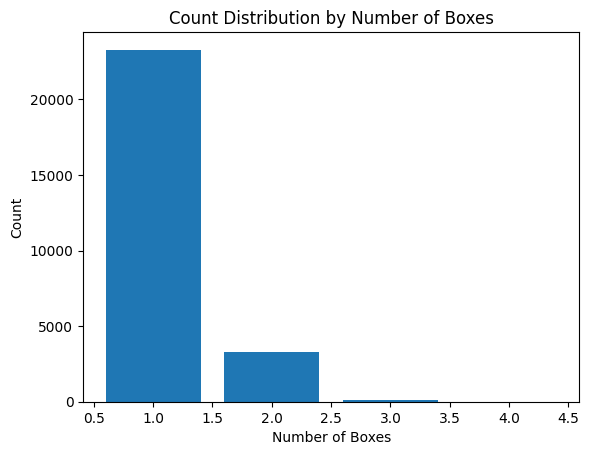

In [ ]:
plt.bar(bboxes_summary['number_of_boxes'], bboxes_summary['count'])
plt.xlabel("Number of Boxes")
plt.ylabel("Count")
_ = plt.title("Count Distribution by Number of Boxes")

In [ ]:
# Iterate through the bboxes_summary DataFrame and print each row in a human-readable format
print("\nNumber of bounding boxes per patientID count in the dataset:")

for _, row in bboxes_summary.iterrows():
    print(f"Patient IDs count: {row['count']} | Bounding boxes: {row['number_of_boxes']}")


Number of bounding boxes per patientID count in the dataset:
Patient IDs count: 23286 | Bounding boxes: 1
Patient IDs count: 3266 | Bounding boxes: 2
Patient IDs count: 119 | Bounding boxes: 3
Patient IDs count: 13 | Bounding boxes: 4


**Merge dataset**

In [ ]:
train_dataset = pd.concat([train_metadata, train_class_labels['class']], axis = 1)
print("Merged train_dataset:")
train_dataset.head()

Merged train_dataset:


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

In [ ]:
print(f'train_dataset has {train_dataset.shape[0]} rows and {train_dataset.shape[1]} columns')

train_dataset has 30227 rows and 7 columns


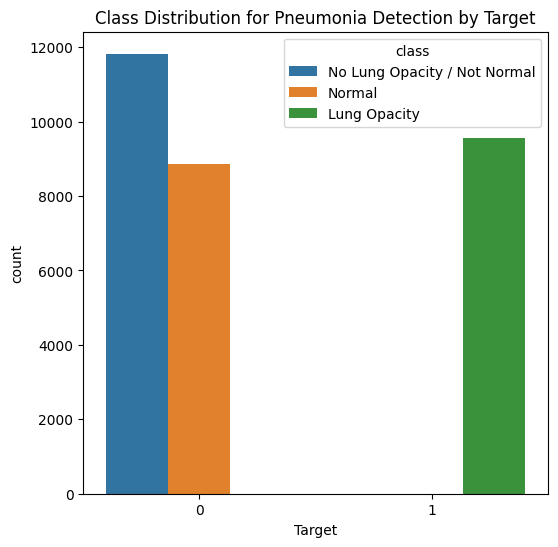

In [ ]:
# Create a figure and axis object for the plot
fig, ax = plt.subplots(nrows=1, figsize=(6, 6))

# Group the data by 'Target' and 'class' and count the occurrences
class_counts = train_dataset.groupby(['Target', 'class']).size().reset_index(name='count')

# Create the bar plot with seaborn
sns.barplot(ax=ax, x='Target', y='count', hue='class', data=class_counts)

# Set the title for the plot
plt.title('Class Distribution for Pneumonia Detection by Target')

# Show the plot
plt.show()

To effectively manage and analyze this data, we can break it down into the following components:

* **Patient IDs** Some of which are duplicated due to multiple bounding boxes per patient

* **Bounding box coordinates:** Defined by x, y, width, and height

* **Target:**
Target = 1 indicates the presence of pneumonia.
Target = 0 indicates no definitive evidence of pneumonia.

* **Class Labels:** The dataset also includes a class label with three possible categories:
  * Lung Opacity: Suggests the presence of pneumonia (corresponding to Target = 1).
  * Normal or No Lung Opacity / Not Normal: Corresponds to Target = 0 (indicating no pneumonia).

* **Bounding Box Distribution:** A large proportion of patient IDs (23,286 or 87%) have only one bounding box.
A small number of patients (13 individuals) have up to four bounding boxes, potentially indicating multiple findings within a single image.

**Reading the DICOM file**

In [ ]:
sample_patientId = train_labels['patientId'][0]
dcm_file = '/content/drive/MyDrive/Dataset/stage_2_train_images/'+'{}.dcm'.format(sample_patientId)
dcm_data = dcm.dcmread(dcm_file)

print('Metadata of the image consists of \n', dcm_data)

Metadata of the image consists of 
 Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 202
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0002,0010) Transfer Syntax UID                 UI: JPEG Baseline (Process 1)
(0002,0012) Implementation Class UID            UI: 1.2.276.0.7230010.3.0.3.6.0
(0002,0013) Implementation Version Name         SH: 'OFFIS_DCMTK_360'
-------------------------------------------------
(0008,0005) Specific Character Set              CS: 'ISO_IR 100'
(0008,0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008,0018) SOP Instance UID                    UI: 1.2.276.0.7230010.3.1.4.8323329.28530.1517874485.775526
(0008,0020) Study Date                          DA: '19010101'
(000

#### Observations:
The DICOM metadata contains both patient information and technical details about the image:

* **Patient Information:** This includes identifiers (such as name and ID), demographic details (like age and sex), and the body part examined (in this case, "CHEST").

* **Image Technical Details:** The metadata also provides information about the image itself, such as its resolution (1024x1024 pixels), pixel spacing, and compression format (e.g., JPEG).

Additionally, the DICOM standard includes information about the imaging device, study, and series, all of which play a crucial role in organizing and managing medical imaging data.

Following analysis derived from the image data

* **Age Distribution:** Investigate the age distribution of patients with evidence of lung opacity versus those without definitive evidence. This analysis will help identify any age-related trends or patterns in patients with and without signs of lung opacity.

* **Gender Distribution:** Analyze the distribution of male and female patients within the groups with and without lung opacity evidence. This could uncover any gender-based differences in the prevalence of lung opacity.

* **View Positions:** Examine the different imaging view positions (e.g., PA) in the dataset to understand how the images were captured. This could provide insights into imaging protocols or preferences used during the chest examinations.

* **Imaging Modality:** Explore the imaging modalities used (e.g., CR, CT) to gain a better understanding of the types of equipment or methods employed in capturing these chest X-ray images.

In [ ]:
print('Number of images in training images folders are: {}.'.format(len(os.listdir('/content/drive/MyDrive/Dataset/stage_2_train_images'))))

Number of images in training images folders are: 26684.


In [ ]:
# Define path to the training images
training_image_path = '/content/drive/MyDrive/Dataset/stage_2_train_images'

# Create a DataFrame with paths to each .dcm file in the specified directory
images = pd.DataFrame({'path': glob(os.path.join(training_image_path, '*.dcm'))})

# Extract patientId by removing the file extension and directory path
images['patientId'] = images['path'].apply(lambda x: os.path.splitext(os.path.basename(x))[0])

# Display the column names in the DataFrame
print(f"Columns in the training images DataFrame: {list(images.columns)}")

Columns in the training images DataFrame: ['path', 'patientId']


In [ ]:
# Merging the images dataframe with merge_data dataframe
train_dataset = train_dataset.merge(images, on = 'patientId', how = 'left')
print('After merging the two dataframe, the merge_data has {} rows and {} columns.'.format(train_dataset.shape[0], train_dataset.shape[1]))

After merging the two dataframe, the merge_data has 30227 rows and 8 columns.


In [ ]:
train_dataset.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  \
0  No Lung Opacity / Not Normal   
1  No Lung Opacity / Not Normal   
2  No Lung Opacity / Not Normal   
3                        Normal   
4                  Lung Opacity   

                                                path  
0  /content/drive/MyDrive/Dataset/stage_2_train_i...  
1  /content/drive/MyDrive/Dataset/stage_2_train_i...  
2  /content/drive/MyDrive/Dataset/stage_2_train_i...  
3  /content/drive/MyDrive/Dataset/stage_2_train_i...  
4  /content/drive/MyDrive/Dataset/stage_2_train_i...

In [ ]:
# List of columns to add to the DataFrame
columns_to_add = ['Modality', 'PatientAge', 'PatientSex', 'BodyPartExamined',
                  'ViewPosition']

def parse_dicom_data(data_df, data_path):
    # Initialize empty columns for new features
    for col in columns_to_add:
        data_df[col] = None

    # List all image filenames in the specified directory
    image_names = os.listdir(data_path)

    # Iterate over the image files with a progress bar
    for img_name in tqdm(image_names, desc="Processing DICOM files"):
        image_path = os.path.join(data_path, img_name)
        try:
            # Attempt to read the DICOM file
            dicom_data = dcm.dcmread(image_path, force=True)

            # Ensure the DICOM file contains a 'PatientID'
            if 'PatientID' in dicom_data:
                # Find the corresponding row in the DataFrame based on PatientID
                patient_idx = data_df['patientId'] == dicom_data.PatientID

                # Extract and assign metadata from the DICOM file to the DataFrame
                data_df.loc[patient_idx, 'Modality'] = getattr(dicom_data, 'Modality', None)
                data_df.loc[patient_idx, 'PatientAge'] = pd.to_numeric(getattr(dicom_data, 'PatientAge', None), errors='coerce')
                data_df.loc[patient_idx, 'PatientSex'] = getattr(dicom_data, 'PatientSex', None)
                data_df.loc[patient_idx, 'BodyPartExamined'] = getattr(dicom_data, 'BodyPartExamined', None)
                data_df.loc[patient_idx, 'ViewPosition'] = getattr(dicom_data, 'ViewPosition', None)
                #data_df.loc[patient_idx, 'ConversionType'] = getattr(dicom_data, 'ConversionType', None)
                #data_df.loc[patient_idx, 'Rows'] = getattr(dicom_data, 'Rows', None)
                #data_df.loc[patient_idx, 'Columns'] = getattr(dicom_data, 'Columns', None)
                #data_df.loc[patient_idx, 'PixelSpacing'] = str(getattr(dicom_data, 'PixelSpacing', [None])[0])

        except dcm.errors.InvalidDicomError:
            print(f"Skipping non-DICOM file: {img_name}")
        except Exception as e:
            print(f"Error processing file {img_name}: {e}")

# Example usage:
parse_dicom_data(train_dataset, '/content/drive/MyDrive/Dataset/stage_2_train_images/')


Processing DICOM files: 100%|██████████| 26684/26684 [08:17<00:00, 53.65it/s] 


In [ ]:
print('After parsing the information from the dicom images, train_dataset has {} rows and {} columns:\n'.format(train_dataset.shape[0],train_dataset.shape[1]))

After parsing the information from the dicom images, train_dataset has 30227 rows and 13 columns:



In [ ]:
train_dataset.head()

patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  \
0  No Lung Opacity / Not Normal   
1  No Lung Opacity / Not Normal   
2  No Lung Opacity / Not Normal   
3                        Normal   
4                  Lung Opacity   

                                                path Modality PatientAge  \
0  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         51   
1  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         48   
2  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         19   
3  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         28   
4  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         32   

  PatientSex BodyPartExamined ViewPosition  
0          F            CHEST           PA  
1          F            CHEST           PA  
2          M            CHEST           AP  
3          M            CHEST           PA  
4          F            CHEST           AP

**Import dataset to pickle**

In [ ]:
train_dataset.to_pickle('train_dataset.pkl')

In [ ]:
train_dataset = pd.read_pickle('train_dataset.pkl')
print(f'train_dataset consists of {train_dataset.shape[0]} rows and {train_dataset.shape[1]} columns: \n')
train_dataset.head()

train_dataset consists of 30227 rows and 13 columns: 



patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  \
0  No Lung Opacity / Not Normal   
1  No Lung Opacity / Not Normal   
2  No Lung Opacity / Not Normal   
3                        Normal   
4                  Lung Opacity   

                                                path Modality PatientAge  \
0  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         51   
1  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         48   
2  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         19   
3  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         28   
4  /content/drive/MyDrive/Dataset/stage_2_train_i...       CR         32   

  PatientSex BodyPartExamined ViewPosition  
0          F            CHEST           PA  
1          F            CHEST           PA  
2          M            CHEST           AP  
3          M            CHEST           PA  
4          F            CHEST           AP

### Perform Exploratory Data Analysis (EDA)

In [ ]:
print('All images are obtained with one modality, which is: {} \n'.format(train_dataset['Modality'].unique()[0]))

All images are obtained with one modality, which is: CR 



In [ ]:
print('All images are examined on one body part, which is {} area.\n'.format(train_dataset['BodyPartExamined'].unique()[0]))

All images are examined on one body part, which is CHEST area.



In [ ]:
def get_feature_distribution(data, feature):
    """
    Prints the distribution of a given feature in the dataset,
    including the count and percentage of each unique value.

    Parameters:
    data (DataFrame): The dataset containing the feature.
    feature (str): The name of the feature (column) to analyze.
    """

    print(f"Distribution for Feature: '{feature}'")

    # Calculate total count, value counts, and percentage distribution
    total_count = len(data)
    value_counts = data[feature].value_counts()
    percentages = data[feature].value_counts(normalize=True) * 100

    # Print the distribution for each unique value in the feature
    for value, count in value_counts.items():
        percentage = percentages[value]
        print(f"{value:<30}: {count} occurrences ({percentage:.2f}%) of total data")

# Example usage:
get_feature_distribution(train_dataset, 'ViewPosition')


Distribution for Feature: 'ViewPosition'
AP                            : 15297 occurrences (50.61%) of total data
PA                            : 14930 occurrences (49.39%) of total data


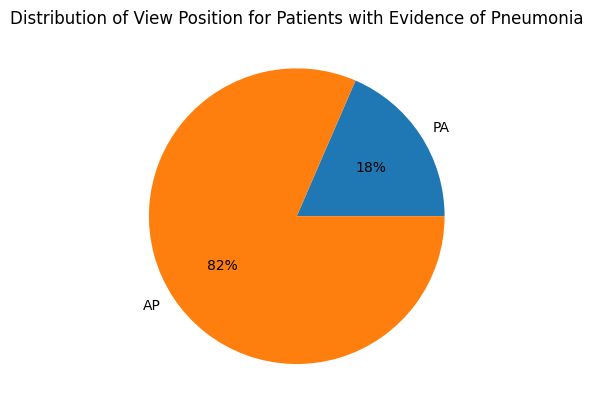

In [ ]:
# Plot the distribution of 'ViewPosition' for patients with evidence of pneumonia (Target == 1)
_ = train_dataset.loc[train_dataset['Target'] == 1, 'ViewPosition'] \
    .value_counts() \
    .sort_index(ascending=False) \
    .plot(kind='pie', autopct='%.0f%%', legend=False, title='Distribution of View Position for Patients with Evidence of Pneumonia') \
    .set_ylabel('')

#### View Positions in the Training Dataset:

* The training dataset includes two main View Positions used for chest X-rays: AP (Anterior/Posterior) and PA (Posterior/Anterior).

* Both are primarily employed to capture the front view of the chest, with a lateral view often taken as a complementary angle.

**Posterior/Anterior (PA):**

* In a PA X-ray, the X-ray beam passes from the posterior (back) to the
anterior (front) of the chest.
* The patient is typically asked to stand with their chest against the film or detector.
* As a result of this positioning, the heart appears on the right side of the image when viewed.
* PA images are generally of higher quality and offer a more accurate representation of heart size, making them the preferred view for chest X-rays.

**Anterior/Posterior (AP):**
* AP X-rays are used when a PA image cannot be obtained, often due to the patient's inability to stand (e.g., in cases of severe illness).
* In this view, the X-ray beam passes from the anterior (front) to the posterior (back) of the chest.
* AP images may result in an exaggerated appearance of the heart size, as the patient is often lying down or seated during the procedure, altering the geometry of the chest in relation to the X-ray beam.

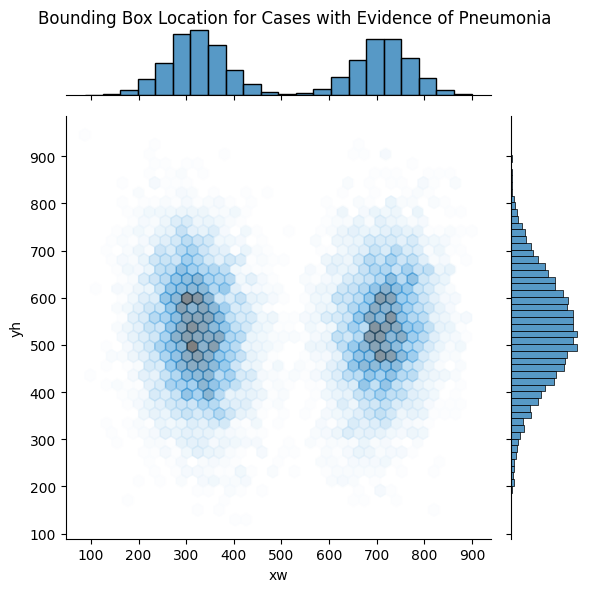

In [ ]:
# Plot the x and y centers of bounding boxes for cases with evidence of pneumonia
bboxes = train_dataset[train_dataset['Target'] == 1]
bboxes['xw'] = bboxes['x'] + bboxes['width'] / 2  # Calculate the x-center of the bounding box
bboxes['yh'] = bboxes['y'] + bboxes['height'] / 2  # Calculate the y-center of the bounding box

# Create a hexbin plot for the bounding box centers
g = sns.jointplot(x='xw', y='yh', data=bboxes, kind='hex', alpha=0.5)

# Add title to the plot
plt.suptitle('Bounding Box Location for Cases with Evidence of Pneumonia')

# Adjust the layout to fit the title
plt.tight_layout()
plt.subplots_adjust(top=0.95)

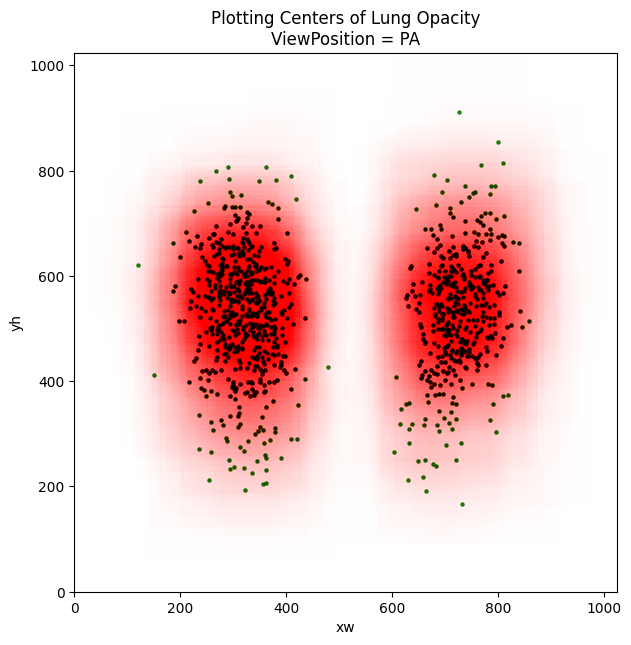

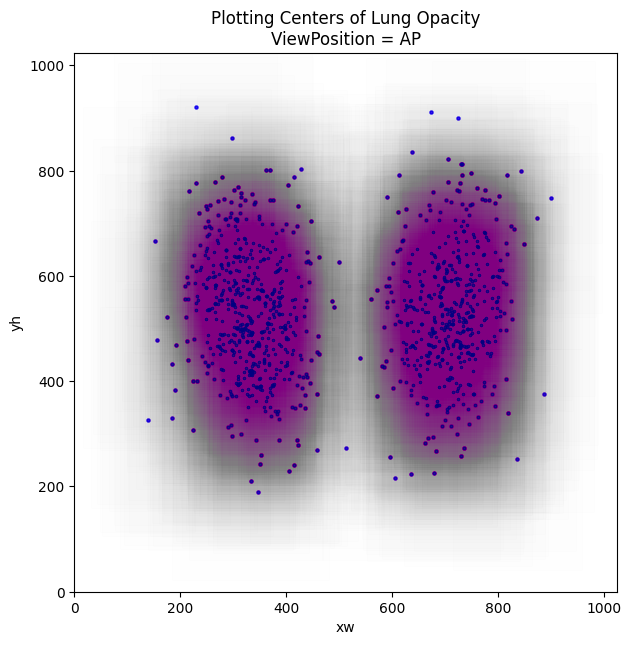

In [ ]:
def plot_bboxes_scatter(data, color_point, color_window, title_text):
    """
    Plots the centers of bounding boxes along with their respective windows (bounding boxes).

    Parameters:
    - data (DataFrame): The dataset containing bounding box coordinates and view positions.
    - color_point (str): The color for plotting the bounding box centers (scatter points).
    - color_window (str): The color for the bounding box windows.
    - title_text (str): Additional text to display in the plot title.
    """
    # Create the figure and axis for the plot
    fig, ax = plt.subplots(figsize=(7, 7))

    # Set the plot title
    ax.set_title(f'Plotting Centers of Lung Opacity\n{title_text}')

    # Plot the scatter points representing bounding box centers
    data.plot.scatter(x='xw', y='yh', ax=ax, alpha=0.8, marker='.', color=color_point, xlim=(0, 1024), ylim=(0, 1024))

    # Add the bounding box windows (rectangles) to the plot
    for _, sample in data.iterrows():
        ax.add_patch(Rectangle(
            xy=(sample['x'], sample['y']),
            width=sample['width'],
            height=sample['height'],
            alpha=0.0035,  # Adjust transparency of bounding boxes
            color=color_window
        ))

# Sample data for PA and AP view positions (subsetting 1000 samples)
data_PA = bboxes[bboxes['ViewPosition'] == 'PA'].sample(1000)
data_AP = bboxes[bboxes['ViewPosition'] == 'AP'].sample(1000)

# Plot the bounding boxes for PA and AP view positions with appropriate colors
plot_bboxes_scatter(data_PA, 'green', 'red', 'ViewPosition = PA')
plot_bboxes_scatter(data_AP, 'blue', 'purple', 'ViewPosition = AP')

#### Observations: BodyPartExamined & ViewPosition
**BodyPartExamined:** The "BodyPartExamined" attribute is consistent across all cases in the training dataset, with the value being "CHEST" as expected.

**Modality:** The dataset contains a single modality type, CR (Computer Radiography), indicating that all images were taken using this technique.

**ViewPosition:** In the overall dataset, the ViewPosition is nearly evenly distributed across different types. However, when focusing on cases where Target = 1 (i.e., pneumonia cases), the majority of the images are captured with the AP (Anterior/Posterior) view.

Distribution of Target Variable by Gender:
class       Lung Opacity  No Lung Opacity / Not Normal  Normal
PatientSex                                                    
F                   3995                          5111    3905
M                   5560                          6710    4946


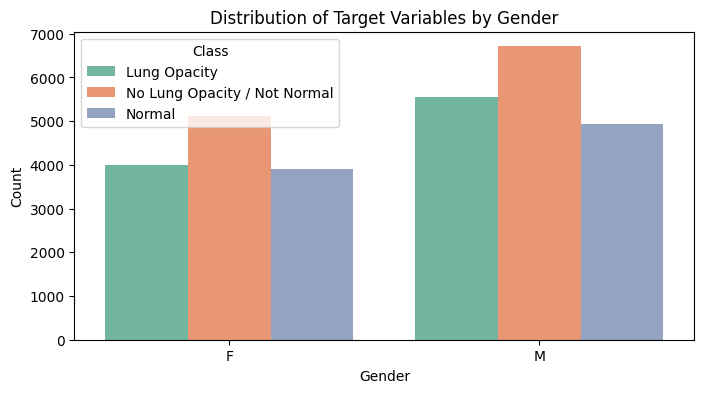

In [ ]:
# Distribution of Target Variables by Gender

# Count the distribution of 'Target' for each gender and class
target_distribution = train_dataset.groupby(['PatientSex', 'class']).size().reset_index(name='Count')

# Pivot the data for easier plotting
pivot_gender = target_distribution.pivot(index='PatientSex', columns='class', values='Count')

# Display the distribution of the Target variable by gender
print("Distribution of Target Variable by Gender:")
print(pivot_gender)

# Visualization: Stacked bar plot
plt.figure(figsize=(8, 4))
sns.barplot(
    data=target_distribution,
    x='PatientSex',
    y='Count',
    hue='class',
    palette='Set2'
)

# Add labels, title, and legend to the plot
plt.title('Distribution of Target Variables by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Class', loc='upper left')
plt.show()

Distribution of Age vs Lung Opacity by Age Group:
class     Lung Opacity  No Lung Opacity / Not Normal  Normal
AgeGroup                                                    
0-18               678                           490     530
19-30             1451                          1395    1363
31-50             3266                          3631    3325
51-70             3539                          5361    3276
71-100+            621                           942     354


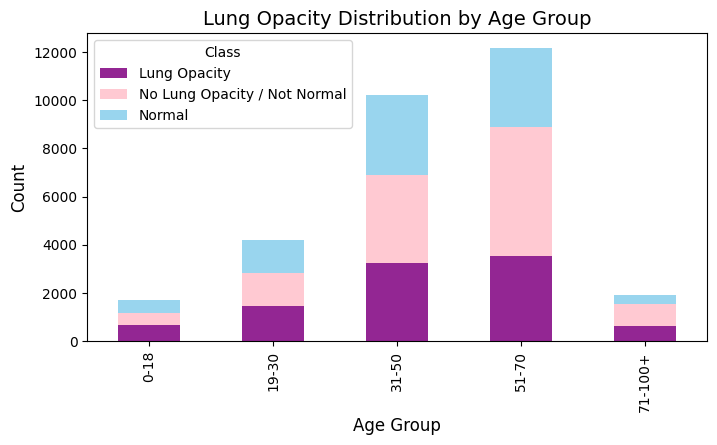

In [ ]:
# Distribution of Age vs Lung Opacity

# Define age groups using bin ranges
bins = [0, 18, 30, 50, 70, 100]  # Age group boundaries
labels = ['0-18', '19-30', '31-50', '51-70', '71-100+']  # Age group labels

# Create a new column 'AgeGroup' in the dataset by binning the 'PatientAge'
train_dataset['AgeGroup'] = pd.cut(train_dataset['PatientAge'], bins=bins, labels=labels)

# Calculate the distribution of the 'Target' variable for each AgeGroup and class
age_group_distribution = train_dataset.groupby(['AgeGroup', 'class']).size().reset_index(name='count')

# Pivot the data for easier plotting (stacked bar chart)
pivot_data = age_group_distribution.pivot(index='AgeGroup', columns='class', values='count').fillna(0)

# Display the distribution of age groups vs lung opacity
print("Distribution of Age vs Lung Opacity by Age Group:")
print(pivot_data)

# Plotting the stacked bar chart
pivot_data.plot(
    kind='bar',
    stacked=True,
    figsize=(8, 4),
    color=['purple', 'pink', 'skyblue'],
    alpha=0.85
)

# Add titles and axis labels
plt.title('Lung Opacity Distribution by Age Group', fontsize=14)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Class', loc='upper left')
plt.show()

* Lung opacity is more prevalent in older age groups, particularly in those aged 51-70, suggesting an age-related increase in both the prevalence and risk of lung opacity.

* Younger age groups (0-18 and 19-30) mostly show "Normal" results, indicating a lower susceptibility or fewer cases of lung opacity in these populations.

* As age increases, the proportion of "Lung Opacity" cases rises, while the proportion of "Normal" cases declines.

* The "No Lung Opacity / Not Normal" category remains relatively consistent across all age groups.

**Healthcare Implications:**
* Given the higher prevalence of lung opacity in middle-aged and older adults (31-70+), screening and preventive measures should focus on these age groups to better address and manage the associated risks.

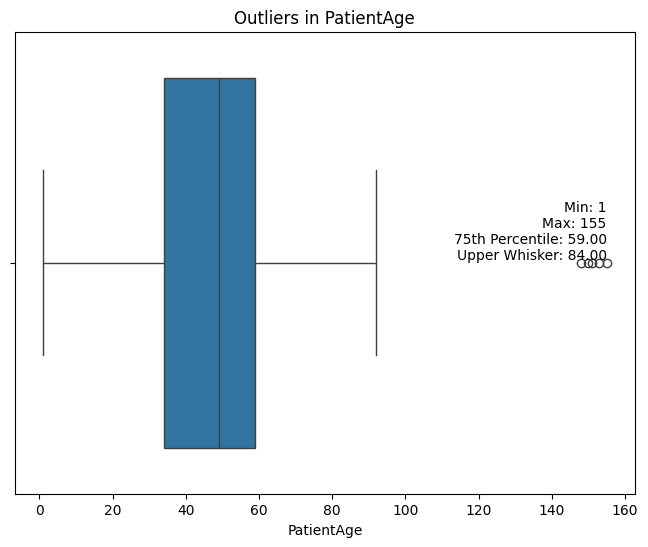

In [ ]:
# Checking outliers in 'PatientAge'

# Calculate key statistics for 'PatientAge'
min_age = train_dataset['PatientAge'].min()
max_age = train_dataset['PatientAge'].max()
age_75th_percentile = train_dataset['PatientAge'].quantile(0.75)
age_iqr_upper = age_75th_percentile + (age_75th_percentile - train_dataset['PatientAge'].quantile(0.25))

# Visualize the distribution and outliers in 'PatientAge' using a boxplot
fig = plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=train_dataset['PatientAge'], orient='h')
ax.set_title('Outliers in PatientAge')

# Display the calculated statistics on the plot
ax.text(
    x=max_age, y=0,
    s=f'Min: {min_age}\nMax: {max_age}\n75th Percentile: {age_75th_percentile:.2f}\nUpper Whisker: {age_iqr_upper:.2f}',
    ha='right', va='bottom', fontsize=10, color='black'
)

plt.show()

In [ ]:
# Removing outliers from 'PatientAge'

# Define the upper threshold for 'PatientAge' (e.g., 100)
max_age_threshold = 100

# Clip the 'PatientAge' values to remove outliers above the defined threshold
train_dataset['PatientAge'] = train_dataset['PatientAge'].clip(lower=train_dataset['PatientAge'].min(), upper=max_age_threshold)

# Calculate and display the updated descriptive statistics for 'PatientAge'
summary_stats = train_dataset['PatientAge'].describe().astype(int)
summary_stats


count     30227
unique       93
top          58
freq        955
Name: PatientAge, dtype: int64

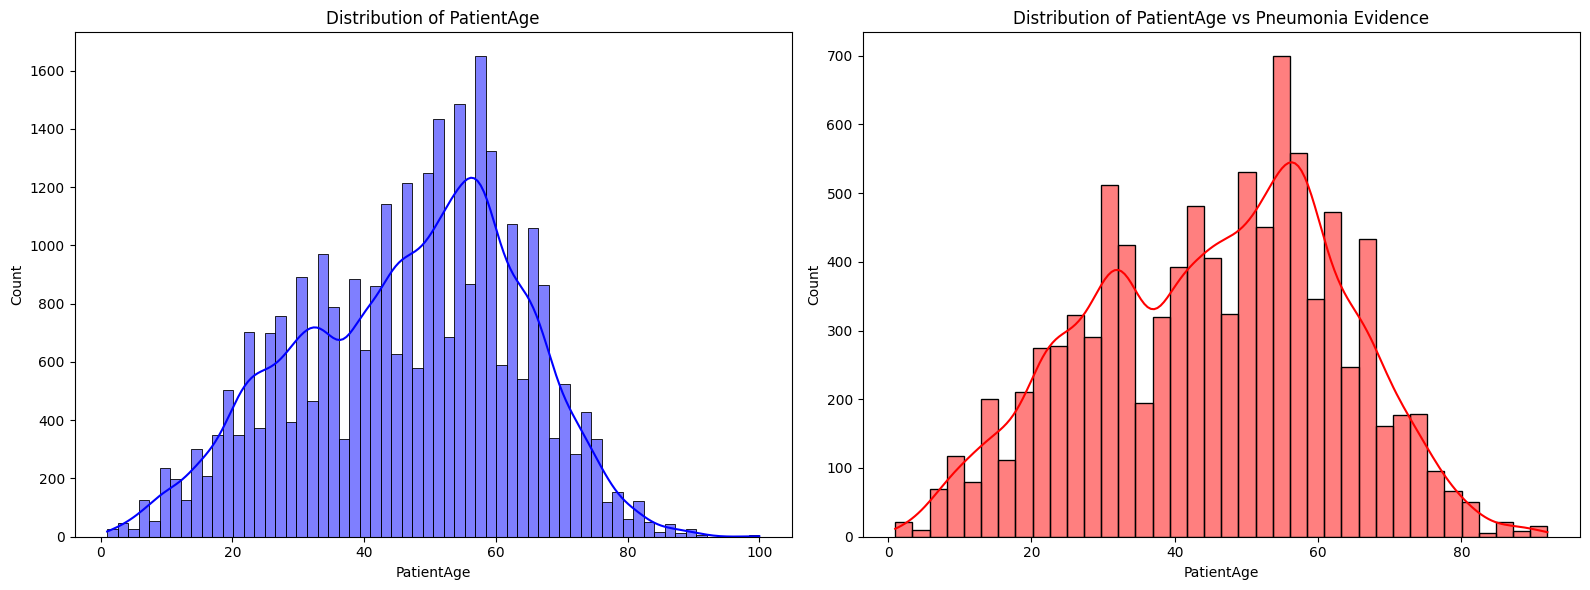

In [ ]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot distribution of 'PatientAge' for the entire dataset
sns.histplot(train_dataset['PatientAge'], kde=True, ax=axes[0], color='blue')
axes[0].set_title('Distribution of PatientAge')

# Plot distribution of 'PatientAge' for cases with Target = 1 (pneumonia evidence)
sns.histplot(train_dataset.loc[train_dataset['Target'] == 1, 'PatientAge'], kde=True, ax=axes[1], color='red')
axes[1].set_title('Distribution of PatientAge vs Pneumonia Evidence')

# Display the plot
plt.tight_layout()
plt.show()

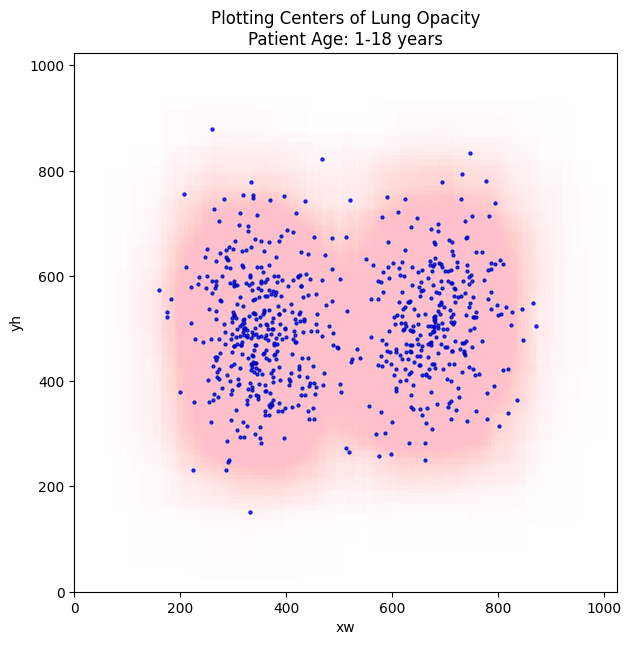

In [ ]:
# Create age-based data subsets
age_groups = {
    '18 and under': bboxes[bboxes['PatientAge'] < 19],
    '19-30': bboxes[(bboxes['PatientAge'] >= 19) & (bboxes['PatientAge'] < 31)],
    '31-50': bboxes[(bboxes['PatientAge'] >= 31) & (bboxes['PatientAge'] < 51)],
    '51-70': bboxes[(bboxes['PatientAge'] >= 51) & (bboxes['PatientAge'] < 71)],
    '71-90': bboxes[(bboxes['PatientAge'] >= 71) & (bboxes['PatientAge'] < 100)]
}

# Scatter plot for patients aged 1-18 years
plot_bboxes_scatter(age_groups['18 and under'], 'blue', 'pink', 'Patient Age: 1-18 years')

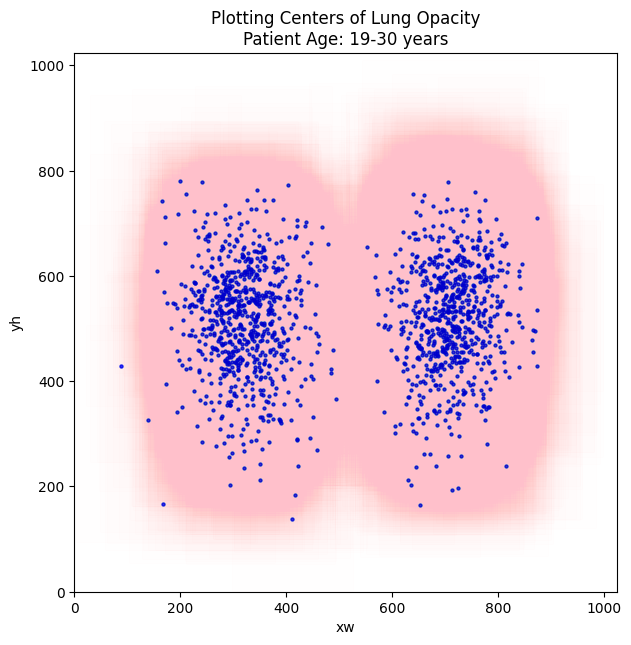

In [ ]:
plot_bboxes_scatter(age_groups['19-30'],'blue', 'pink', 'Patient Age: 19-30 years')

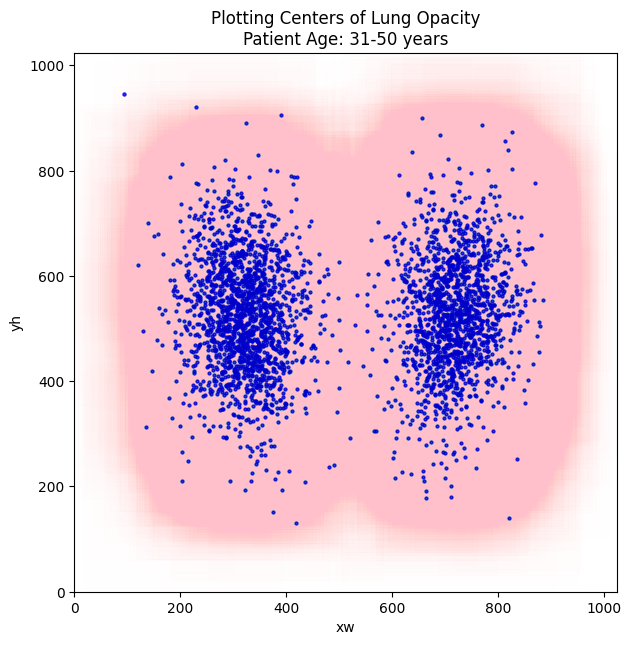

In [ ]:
plot_bboxes_scatter(age_groups['31-50'],'blue', 'pink', 'Patient Age: 31-50 years')

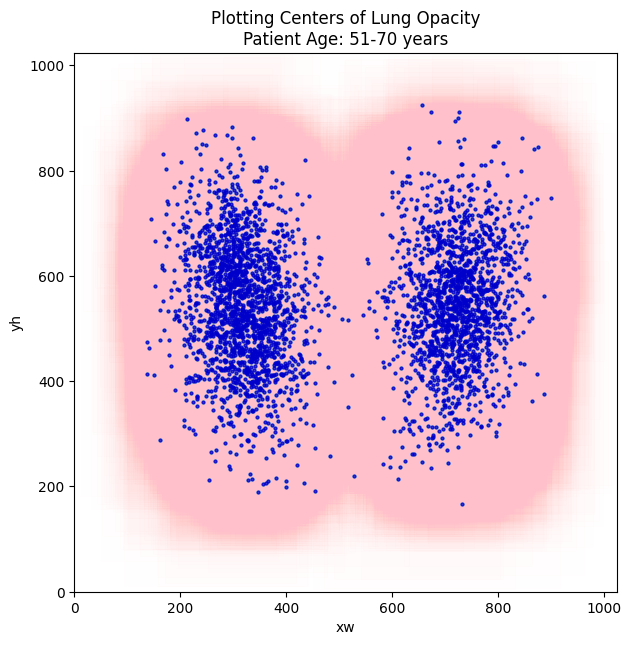

In [ ]:
plot_bboxes_scatter(age_groups['51-70'],'blue', 'pink', 'Patient Age: 51-70 years')

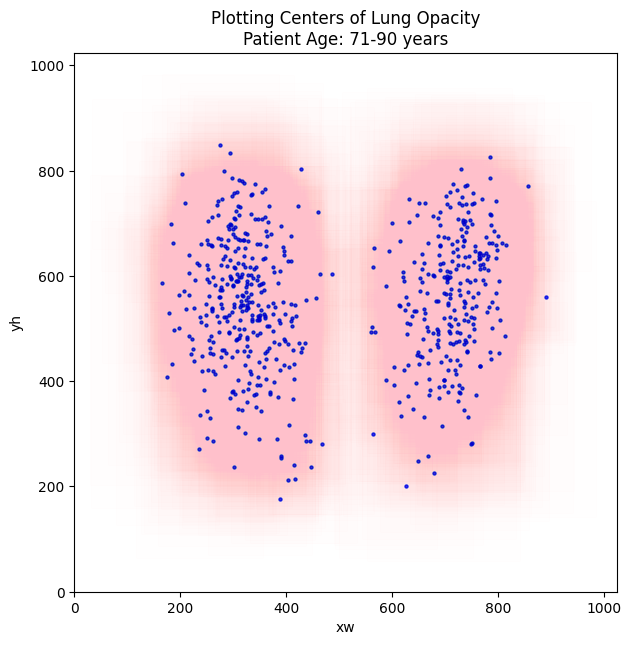

In [ ]:
plot_bboxes_scatter(age_groups['71-90'],'blue', 'pink', 'Patient Age: 71-90 years')

##### Step 5: Display images with bounding box. [ 5 points ]

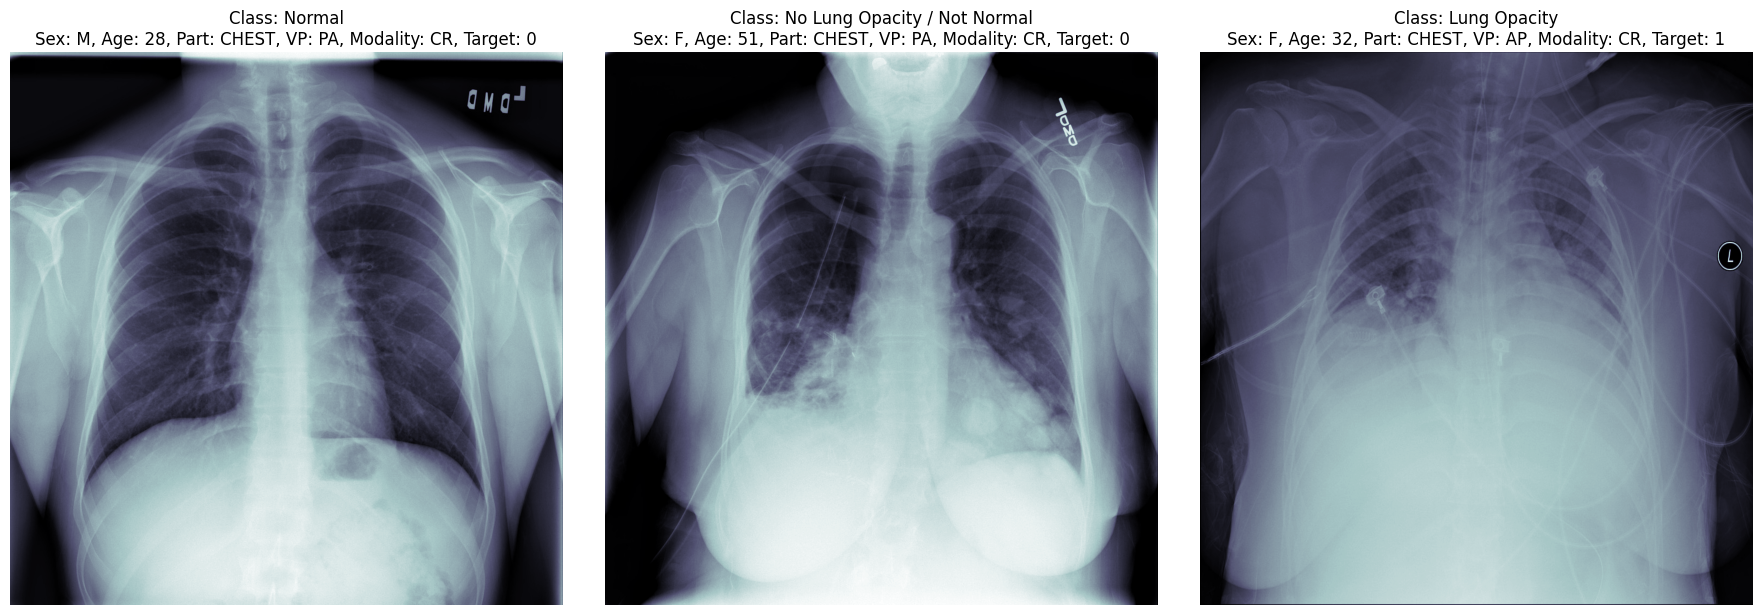

In [ ]:
# Extract samples for each class (Normal, No Lung Opacity / Not Normal, Lung Opacity)
sample_normal = train_dataset.loc[train_dataset['class'] == 'Normal'].iloc[0]
sample_no_lung_opacity = train_dataset.loc[train_dataset['class'] == 'No Lung Opacity / Not Normal'].iloc[0]
sample_lung_opacity = train_dataset.loc[train_dataset['class'] == 'Lung Opacity'].iloc[1]

# Read the corresponding DICOM files
ds_normal = dcm.dcmread(sample_normal['path'])
ds_no_lung_opacity = dcm.dcmread(sample_no_lung_opacity['path'])
ds_lung_opacity = dcm.dcmread(sample_lung_opacity['path'])

# Set up the subplot for displaying the images
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Function to display image with metadata
def display_image(ax, ds, sample, class_label):
    ax.imshow(ds.pixel_array, cmap=plt.cm.bone)
    ax.set_title(f"Class: {class_label}\n"
                 f"Sex: {sample['PatientSex']}, Age: {sample['PatientAge']}, "
                 f"Part: {sample['BodyPartExamined']}, VP: {sample['ViewPosition']}, "
                 f"Modality: {sample['Modality']}, Target: {sample['Target']}")
    ax.axis('off')

# Display the images for each class
display_image(axes[0], ds_normal, sample_normal, 'Normal')
display_image(axes[1], ds_no_lung_opacity, sample_no_lung_opacity, 'No Lung Opacity / Not Normal')
display_image(axes[2], ds_lung_opacity, sample_lung_opacity, 'Lung Opacity')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


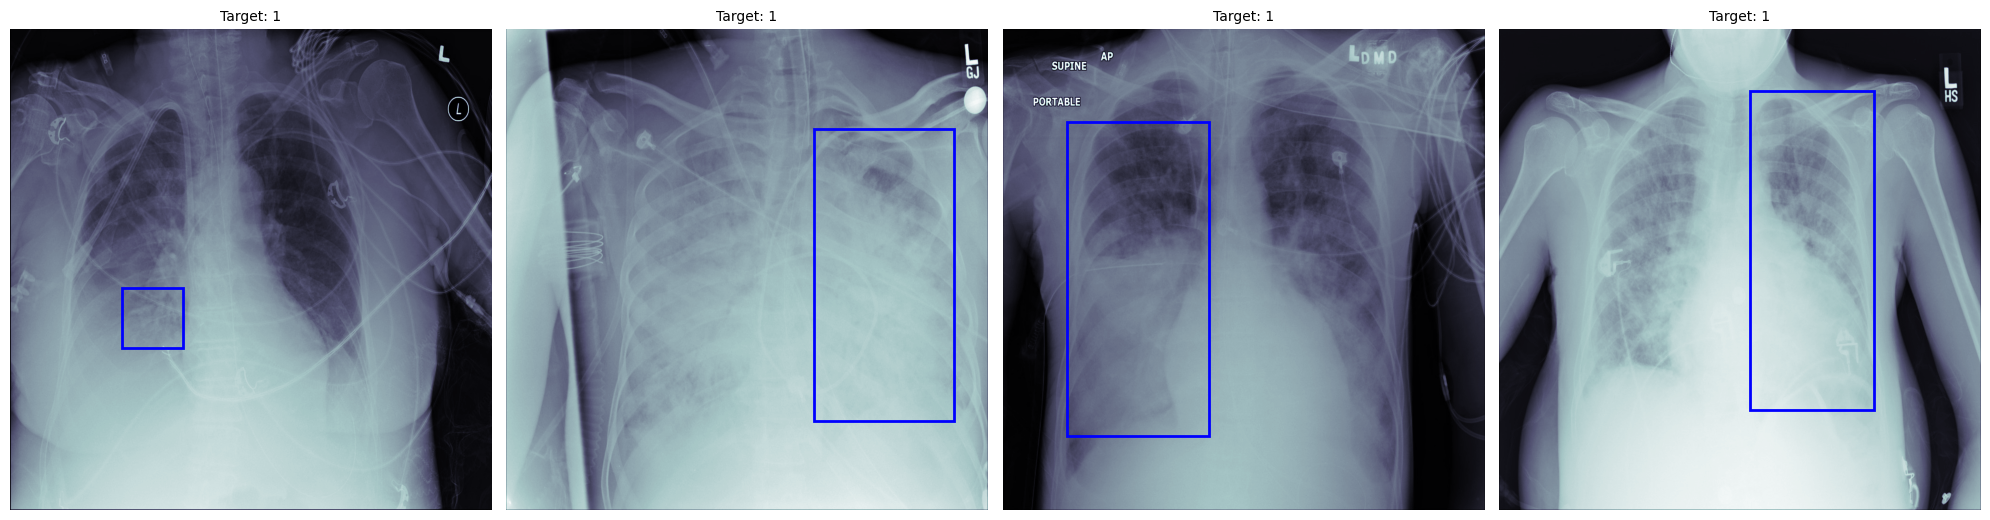

In [ ]:
# Function to display random DICOM images with bounding boxes
def show_dicom_images_with_bboxes(data, img_path, num_images=4):
    # Filter for images with bounding boxes (Target == 1)
    bbox_images = data[data['Target'] == 1]

    # Randomly sample images
    sampled_images = bbox_images.sample(num_images, random_state=42)

    # Initialize subplot for displaying images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))

    # Loop through sampled images and display each one with bounding box
    for ax, (_, row) in zip(axes, sampled_images.iterrows()):
        # Construct the full path to the DICOM image
        dicom_path = f"{img_path}/{row['path'].split('/')[-1]}"

        # Read the DICOM image
        ds = dcm.dcmread(dicom_path)
        image = ds.pixel_array

        # Display the DICOM image in grayscale using bone colormap
        ax.imshow(image, cmap=plt.cm.bone)
        ax.set_title(f"Target: {row['Target']}", fontsize=10)

        # Extract bounding box coordinates and dimensions
        x, y, width, height = row['x'], row['y'], row['width'], row['height']

        # Create and overlay the bounding box on the image
        rect = Rectangle((x, y), width, height, linewidth=2, edgecolor='blue', facecolor='none')
        ax.add_patch(rect)

        # Hide the axis for cleaner visualization
        ax.axis('off')

    # Adjust layout for better spacing and show the plot
    plt.tight_layout()
    plt.show()

# Example usage: Display 4 random images with bounding boxes
show_dicom_images_with_bboxes(train_dataset, img_path='/content/drive/MyDrive/Dataset/stage_2_train_images')


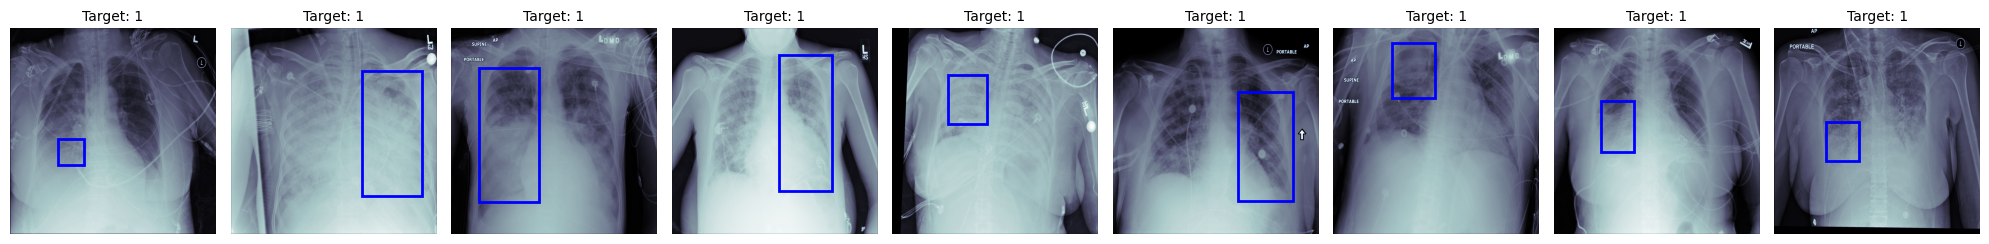

In [ ]:
show_dicom_images_with_bboxes(
    data=train_dataset.loc[train_dataset['Target'] == 1],  # Filter data for Target == 1
    img_path='/content/drive/MyDrive/Dataset/stage_2_train_images/',
    num_images=9
)

#### Conclusion:

* The training dataset, comprising CSV files and the corresponding training image folder, includes data for 26,684 unique patients. Some patients have multiple entries across both CSV files. The majority of the patients fall under Target = 0, indicating no evidence of pneumonia.

* A subset of patients has multiple bounding boxes, with a maximum of four. The "No Lung Opacity / Not Normal" and "Normal" classes are associated with Target = 0, while "Lung Opacity" is linked to Target = 1.

* The images are in DICOM format, from which key patient details such as age, sex, and view position are extracted. Two imaging techniques are used: Anteroposterior (AP) and Posteroanterior (PA). Patient ages range from 1 to 155 years, but for analysis purposes, ages were capped at 100.

* The centers of the bounding boxes are distributed throughout the lung area, although some of these centers are considered outliers.

Step 6: Design, train and test basic CNN models for classification. [ 10 points ]

#### Design, train and test basic CNN models for classification

In [ ]:
from pathlib import Path
from tqdm import tqdm
import pandas as pd
import os
import pydicom as dcm

# Load CSV files for class information and train labels
train_class = pd.read_csv('/content/drive/MyDrive/Dataset/stage_2_detailed_class_info.csv')
train_labels = pd.read_csv('/content/drive/MyDrive/Dataset/stage_2_train_labels.csv')

# Define paths for train and test image directories
train_path = Path('/content/drive/MyDrive/Dataset/stage_2_train_images')
test_path = Path('/content/drive/MyDrive/Dataset/stage_2_test_images')

# Merge train labels with class information
train_meta = pd.concat([train_labels, train_class.drop(columns=['patientId'])], axis=1)

# Create a DataFrame with count of bounding boxes per patient
box_df = train_meta.groupby('patientId').size().reset_index(name='boxes')

# Merge box count into the train metadata
train_ds = pd.merge(train_meta, box_df, on='patientId')

# Count how many patients fall into each bounding box category
box_df = box_df.groupby('boxes').size().reset_index(name='patients')

# List of columns to store DICOM metadata
vars_to_extract = ['PatientAge', 'PatientSex', 'ImagePath']

def process_dicom_data(df, image_path):
    """
    Process DICOM images to extract metadata and add it to the DataFrame.

    Parameters:
    - df: DataFrame with patient information.
    - image_path: Path to the directory containing DICOM images.
    """
    # Add columns to the DataFrame to store extracted DICOM metadata
    for var in vars_to_extract:
        df[var] = None

    # Get list of DICOM image filenames in the directory
    images = os.listdir(image_path)

    # Loop through each image and extract relevant information
    for img_name in tqdm(images, desc="Processing DICOM files"):
        image_file = os.path.join(image_path, img_name)

        try:
            # Read the DICOM file
            img_data = dcm.dcmread(image_file, force=True)

            # Find the corresponding row in the DataFrame based on patient ID
            idx = (df['patientId'] == img_data.PatientID)

            # Extract and assign metadata to the DataFrame
            df.loc[idx, 'PatientAge'] = pd.to_numeric(img_data.PatientAge, errors='coerce')
            df.loc[idx, 'PatientSex'] = img_data.PatientSex
            df.loc[idx, 'ImagePath'] = image_file

        except Exception as e:
            print(f"Error processing file {img_name}: {e}")

# Process DICOM data for training dataset
process_dicom_data(train_ds, '/content/drive/MyDrive/Dataset/stage_2_train_images')


Processing DICOM files: 100%|██████████| 26684/26684 [07:30<00:00, 59.19it/s] 


In [ ]:
train_ds.to_csv('pneumonia_ds', index=False)

In [ ]:
# Initialize empty lists for images and labels
image_list = []
class_labels = []

# Define the target image size
ADJUSTED_IMAGE_SIZE = 128

def read_and_reshape_image(image):
    """
    Reads the image, converts it to a numpy array, and resizes it to the target size.
    """
    img = np.array(image).astype(np.uint8)
    resized_img = cv2.resize(img, (ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE), interpolation=cv2.INTER_LINEAR)
    return resized_img

def populate_images_and_labels(row_data):
    """
    Iterates through each row in the provided metadata, loads the corresponding DICOM images,
    converts them to 3-channel format, resizes them, and stores them in the image list with
    their corresponding class labels.
    """
    for _, row in row_data.iterrows():
        patient_id = row.patientId
        class_label = row["class"]

        # Construct DICOM file path
        dcm_file_path = f'/content/drive/MyDrive/Dataset/stage_2_train_images/{patient_id}.dcm'
        dcm_data = dcm.dcmread(dcm_file_path)
        img = dcm_data.pixel_array

        # Ensure the image has 3 channels (convert grayscale to RGB if necessary)
        if len(img.shape) != 3 or img.shape[2] != 3:
            img = np.stack((img,) * 3, axis=-1)

        # Resize and append the image to the image list
        image_list.append(read_and_reshape_image(img))
        # Append the class label to the label list
        class_labels.append(class_label)

    # Convert lists to numpy arrays before returning
    return np.array(image_list), np.array(class_labels)

# Populate images and labels using metadata
images, labels = populate_images_and_labels(train_meta)

# Print the shapes of the resulting arrays
print(images.shape, labels.shape)


(30227, 128, 128, 3) (30227,)


In [ ]:
# Initialize the LabelBinarizer and encode the labels
label_binarizer = LabelBinarizer()
y_encoded = label_binarizer.fit_transform(labels)

# Split the data into training, testing, and validation sets
from sklearn.model_selection import train_test_split

# First, split the data into training (70%) and testing (30%) sets
X_train, X_test, y_train, y_test = train_test_split(images, y_encoded, test_size=0.3, random_state=50)

# Then, split the test set into validation (50%) and remaining test data (50%)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=50)


In [ ]:
def create_cnn_model(input_height, input_width, input_channels, num_classes):
    """
    Builds and compiles a Convolutional Neural Network model.

    Args:
    input_height (int): Height of the input image.
    input_width (int): Width of the input image.
    input_channels (int): Number of color channels in the input image (e.g., 3 for RGB).
    num_classes (int): Number of output classes for classification.

    Returns:
    model: A compiled CNN model.
    """
    model = Sequential()

    # First Convolutional Layer + MaxPooling + BatchNormalization
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_height, input_width, input_channels), kernel_regularizer=L2(0.001)))
    model.add(BatchNormalization())  # Adding batch normalization to stabilize training
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer + MaxPooling + BatchNormalization
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_regularizer=L2(0.001)))
    model.add(BatchNormalization())  # Adding batch normalization to stabilize training
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Layer + MaxPooling + BatchNormalization
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_regularizer=L2(0.001)))
    model.add(BatchNormalization())  # Adding batch normalization to stabilize training
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output from the convolutional layers
    model.add(Flatten())

    # First Fully Connected Layer
    model.add(Dense(128, activation='relu'))

    # Output Layer with Softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the CNN model
cnn = create_cnn_model(ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3, 3)

# Print the model architecture summary
cnn.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,923 (12.61 MB)

 Trainable params: 3,305,475 (12.61 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
history = cnn.fit(X_train,
                  y_train,
                  epochs = 20,
                  validation_data = (X_val,y_val),
                  batch_size = 16)

Epoch 1/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 16s 8ms/step - accuracy: 0.5179 - loss: 1.3864 - val_accuracy: 0.5757 - val_loss: 1.0232
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5886 - loss: 0.9390 - val_accuracy: 0.5859 - val_loss: 0.9310
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6125 - loss: 0.8748 - val_accuracy: 0.6207 - val_loss: 0.8368
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6264 - loss: 0.8356 - val_accuracy: 0.6265 - val_loss: 0.8268
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6333 - loss: 0.8154 - val_accuracy: 0.5894 - val_loss: 0.8933
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6457 - loss: 0.7998 - val_accuracy: 0.6112 - val_loss: 0.8434
Epoch 7/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.6603 - loss: 0.7769 - val_accuracy: 0.6432 - val_loss: 0.8123
Epoch 8/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.6618 - loss: 0.7658 -

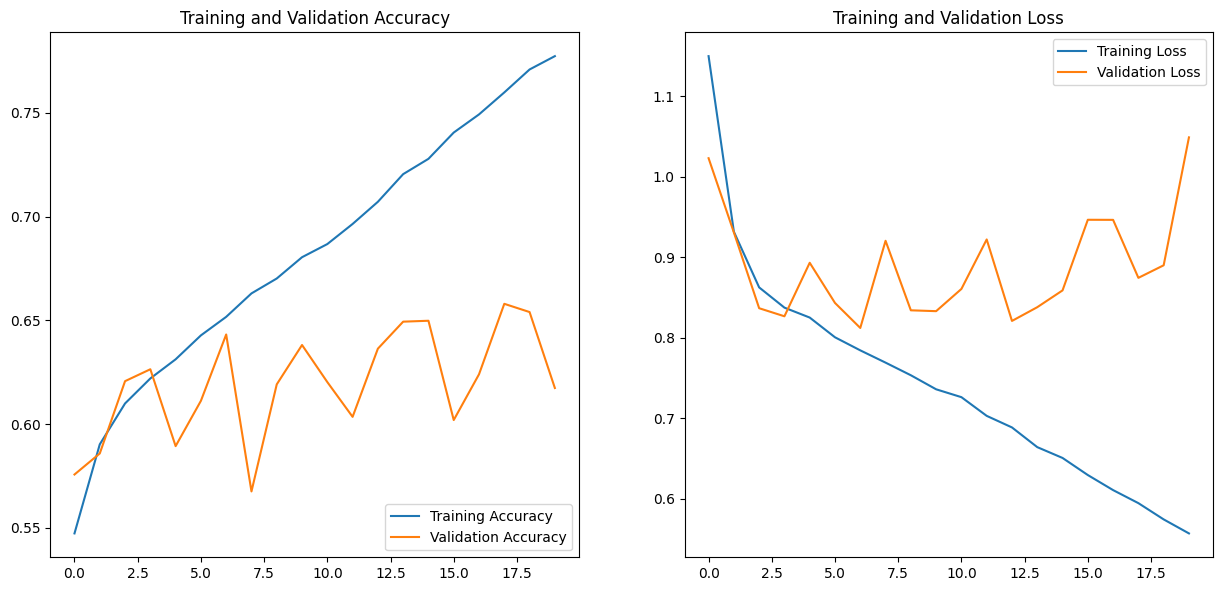

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))  # This ensures the range matches the length of your data

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.2f') if normalize else int(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=12)

    plt.tight_layout()
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

Generating predictions on training set...
662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion matrix, without normalization


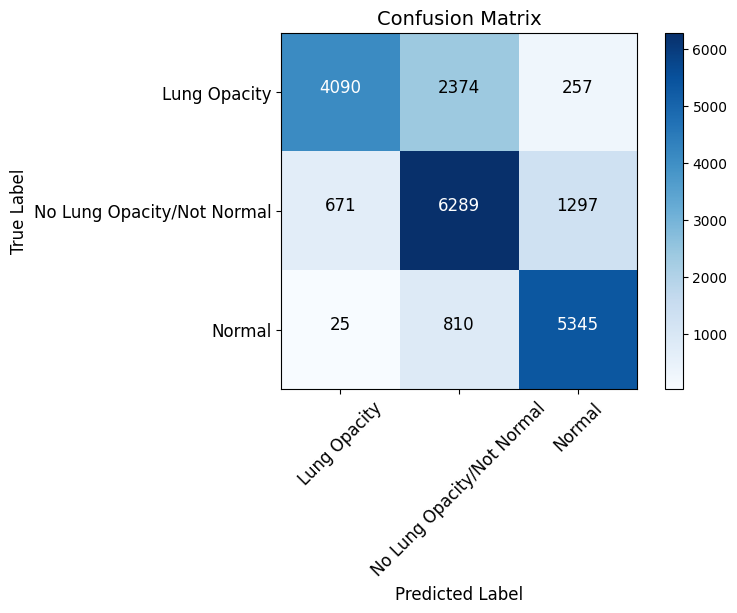


Classification Report:

                            precision    recall  f1-score   support

              Lung Opacity       0.85      0.61      0.71      6721
No Lung Opacity/Not Normal       0.66      0.76      0.71      8257
                    Normal       0.77      0.86      0.82      6180

                  accuracy                           0.74     21158
                 macro avg       0.76      0.75      0.75     21158
              weighted avg       0.76      0.74      0.74     21158



In [ ]:
# Predict the values from the test set
print("Generating predictions on training set...")
Y_pred = cnn.predict(X_train)

# Convert predictions to class indices
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_train, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Display the confusion matrix
class_names = ['Lung Opacity', 'No Lung Opacity/Not Normal', 'Normal']
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False, title='Confusion Matrix')

# Print detailed classification report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

Generating predictions on test set...
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
Confusion matrix, without normalization


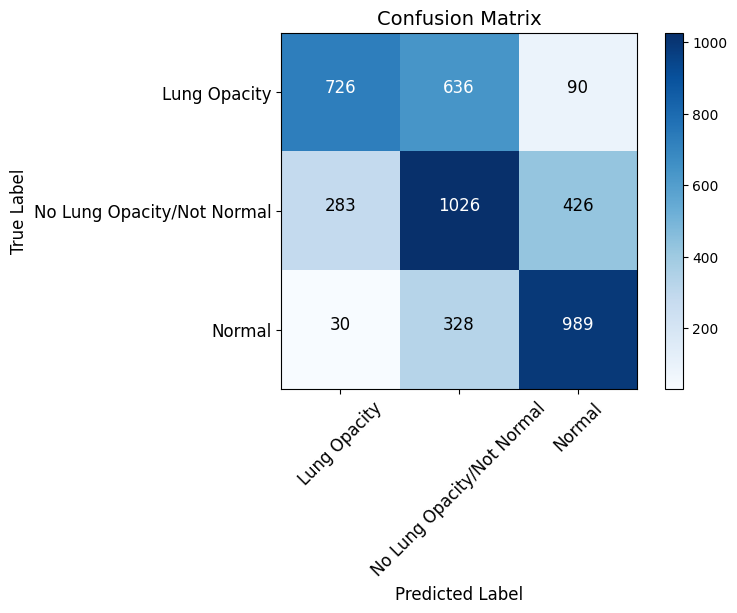


Classification Report:

                            precision    recall  f1-score   support

              Lung Opacity       0.70      0.50      0.58      1452
No Lung Opacity/Not Normal       0.52      0.59      0.55      1735
                    Normal       0.66      0.73      0.69      1347

                  accuracy                           0.60      4534
                 macro avg       0.62      0.61      0.61      4534
              weighted avg       0.62      0.60      0.60      4534



In [ ]:
# Predict the values from the test set
print("Generating predictions on test set...")
Y_pred = cnn.predict(X_test)

# Convert predictions to class indices
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true = np.argmax(y_test, axis=1)

# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Display the confusion matrix
class_names = ['Lung Opacity', 'No Lung Opacity/Not Normal', 'Normal']
plot_confusion_matrix(confusion_mtx, classes=class_names, normalize=False, title='Confusion Matrix')

# Print detailed classification report
print("\nClassification Report:\n")
print(classification_report(Y_true, Y_pred_classes, target_names=class_names))

In [ ]:
class_names = ['Lung Opacity', 'No Lung Opacity/Not Normal', 'Normal']

# Create an empty DataFrame with the defined columns
metrics_df = pd.DataFrame(columns=[
    'Model',
    'Training Accuracy',
    'Validation Accuracy',
    'Testing Accuracy'
])

Y_pred = cnn.predict(X_train)
train_acc = classification_report(np.argmax(y_train, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

Y_pred = cnn.predict(X_val)
val_acc = classification_report(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

Y_pred = cnn.predict(X_test)
test_acc = classification_report(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

# Create a dictionary with the metrics
model_metrics = {
    'Model': "Milestone 1 Model",
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc,
    'Testing Accuracy': test_acc,
}

# Convert the dictionary to a DataFrame
model_metrics_df = pd.DataFrame([model_metrics])

# Append the metrics DataFrame to the original DataFrame
metrics_df = pd.concat([metrics_df, model_metrics_df], ignore_index=True)

# Print the updated DataFrame with the added metrics
metrics_df

662/662 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


Model  Training Accuracy  Validation Accuracy  Testing Accuracy
0  Milestone 1 Model            0.74317              0.61742          0.604543

#### 2. Milestone 2: [ Score: 60 points]
##### Input: Preprocessed output from Milestone - 1
#### Process:
#### Step 1: Fine tune the trained basic CNN models for classification. [5 points]

In [ ]:
def create_basic_cnn_model(input_height, input_width, input_channels, num_classes):
    """
    Builds and compiles a Convolutional Neural Network model.

    Args:
    input_height (int): Height of the input image.
    input_width (int): Width of the input image.
    input_channels (int): Number of color channels in the input image (e.g., 3 for RGB).
    num_classes (int): Number of output classes for classification.

    Returns:
    model: A compiled CNN model.
    """
    model = Sequential()

    # First Convolutional Layer + MaxPooling
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_height, input_width, input_channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Second Convolutional Layer + MaxPooling + BatchNormalization
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Third Convolutional Layer + MaxPooling + BatchNormalization
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # Flatten the output from the convolutional layers
    model.add(Flatten())

    # First Fully Connected Layer
    model.add(Dense(128, activation='relu'))

    # Output Layer with Softmax activation
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model with Adam optimizer and categorical crossentropy loss
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the CNN model
basic_cnn = create_basic_cnn_model(ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3, 3)

# Print the model architecture summary
basic_cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = basic_cnn.fit(X_train,
                  y_train,
                  epochs = 20,
                  validation_data = (X_val,y_val),
                  batch_size = 16)

Epoch 1/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4848 - loss: 4.7698 - val_accuracy: 0.5634 - val_loss: 0.9001
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6085 - loss: 0.8308 - val_accuracy: 0.5956 - val_loss: 0.8531
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6280 - loss: 0.7994 - val_accuracy: 0.6207 - val_loss: 0.8021
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6554 - loss: 0.7473 - val_accuracy: 0.6209 - val_loss: 0.7977
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6771 - loss: 0.7062 - val_accuracy: 0.6130 - val_loss: 0.8750
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7085 - loss: 0.6504 - val_accuracy: 0.6406 - val_loss: 0.8763
Epoch 7/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7400 - loss: 0.5874 - val_accuracy: 0.6097 - val_loss: 0.9644
Epoch 8/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7795 - loss: 0.5139 - 

In [ ]:
Y_pred = basic_cnn.predict(X_train)
train_acc = classification_report(np.argmax(y_train, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

Y_pred = basic_cnn.predict(X_val)
val_acc = classification_report(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

Y_pred = basic_cnn.predict(X_test)
test_acc = classification_report(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

# Create a dictionary with the metrics
basic_model_metrics = {
    'Model': "Base Model",
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc,
    'Testing Accuracy': test_acc,
}

# Convert the dictionary to a DataFrame
basic_model_metrics_df = pd.DataFrame([basic_model_metrics])

# Append the metrics DataFrame to the original DataFrame
metrics_df = pd.concat([metrics_df, basic_model_metrics_df], ignore_index=True)

# Print the updated DataFrame with the added metrics
metrics_df


662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


Model  Training Accuracy  Validation Accuracy  Testing Accuracy
0  Milestone 1 Model           0.743170             0.617420          0.604543
1         Base Model           0.960913             0.632856          0.618218

In [ ]:
def create_fine_tuned_cnn_model(input_height, input_width, input_channels, num_classes):
    """
    Builds and compiles a Convolutional Neural Network model for classification.

    Args:
    input_height (int): Height of the input image.
    input_width (int): Width of the input image.
    input_channels (int): Number of color channels in the input image (e.g., 3 for RGB).
    num_classes (int): Number of output classes for classification.

    Returns:
    model: A compiled CNN model.
    """

    model = Sequential()

    # First Convolutional Layer + MaxPooling + BatchNorm + Dropout
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(input_height, input_width, input_channels)))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Second Convolutional Layer + MaxPooling + BatchNorm + Dropout
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Third Convolutional Layer + MaxPooling + BatchNorm + Dropout
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fourth Convolutional Layer + MaxPooling + BatchNorm + Dropout
    model.add(Conv2D(256, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Fifth Convolutional Layer + MaxPooling + BatchNorm + Dropout
    model.add(Conv2D(512, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Global Average Pooling Layer
    model.add(GlobalAveragePooling2D())

    # Dense Layers with Regularization and Dropout
    model.add(Dense(1024, activation='relu', kernel_regularizer=L2(0.001)))
    model.add(Dropout(0.5))
    model.add(Dense(512, activation='relu', kernel_regularizer=L2(0.001)))
    model.add(Dropout(0.5))

    # Output Layer with softmax for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Print model summary for debugging
    model.summary()

    return model

# Instantiate the CNN model
fine_tuned_cnn = create_basic_cnn_model(ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3, 3)

# Print the model architecture summary
fine_tuned_cnn.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,027 (12.61 MB)

 Trainable params: 3,305,027 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = fine_tuned_cnn.fit(X_train,
                  y_train,
                  epochs = 20,
                  validation_data = (X_val,y_val),
                  batch_size = 16)

Epoch 1/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.4551 - loss: 4.7158 - val_accuracy: 0.5610 - val_loss: 0.9050
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.5797 - loss: 0.8698 - val_accuracy: 0.5773 - val_loss: 0.8703
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6054 - loss: 0.8224 - val_accuracy: 0.6104 - val_loss: 0.8211
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6210 - loss: 0.7976 - val_accuracy: 0.5270 - val_loss: 0.9565
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6125 - loss: 0.8183 - val_accuracy: 0.6137 - val_loss: 0.8334
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6536 - loss: 0.7443 - val_accuracy: 0.6181 - val_loss: 0.8475
Epoch 7/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6719 - loss: 0.7122 - val_accuracy: 0.6267 - val_loss: 0.8353
Epoch 8/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.6908 - loss: 0.6774 - 

In [ ]:
Y_pred = fine_tuned_cnn.predict(X_train)
train_acc = classification_report(np.argmax(y_train, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

Y_pred = fine_tuned_cnn.predict(X_val)
val_acc = classification_report(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

Y_pred = fine_tuned_cnn.predict(X_test)
test_acc = classification_report(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

# Create a dictionary with the metrics
finetuned_model_metrics = {
    'Model': "Finetuned Model",
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc,
    'Testing Accuracy': test_acc,
}

# Convert the dictionary to a DataFrame
fine_tuned_model_metrics_df = pd.DataFrame([finetuned_model_metrics])

# Append the metrics DataFrame to the original DataFrame
metrics_df = pd.concat([metrics_df, fine_tuned_model_metrics_df], ignore_index=True)

# Print the updated DataFrame with the added metrics
metrics_df

662/662 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


Model  Training Accuracy  Validation Accuracy  Testing Accuracy
0  Milestone 1 Model           0.743170             0.617420          0.604543
1         Base Model           0.960913             0.632856          0.618218
2    Finetuned Model           0.903063             0.627784          0.621967

#### Step 2: Apply Transfer Learning model for classification [4 points]

In [ ]:
def create_vgg16_model(input_shape=(ADJUSTED_IMAGE_SIZE, ADJUSTED_IMAGE_SIZE, 3), num_classes=3):
    """
    Builds a CNN model using VGG16 pre-trained weights for transfer learning on RGB images.

    Args:
    - input_shape: Shape of the input image (height, width, channels)
    - num_classes: Number of output classes for classification (2 for binary classification, more for multi-class)

    Returns:
    - model: A compiled CNN model
    """
    # Load VGG16 pre-trained on ImageNet, excluding the top fully connected layers
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model layers (feature extraction only)
    base_model.trainable = False

    # Create the model starting with the base model (VGG16)
    model = Sequential()

    # Add the base model (VGG16)
    model.add(base_model)

    # Add new layers for classification
    model.add(Flatten())  # Flatten the output of the base model
    model.add(Dense(128, activation='relu'))  # Fully connected layer
    model.add(Dropout(0.5))  # Dropout layer to prevent overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    # Compile the model with Adam optimizer and a suitable loss function
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy' if num_classes > 2 else 'binary_crossentropy', metrics=['accuracy'])

    return model

# Example usage for a binary classification problem (2 classes)
vgg16_model = create_vgg16_model(input_shape=(128, 128, 3), num_classes=3)

# Print model summary to check architecture
vgg16_model.summary()

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('vgg16_best_model.keras', monitor='val_loss', save_best_only=True)

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 4, 4, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,763,779 (60.13 MB)

 Trainable params: 1,049,091 (4.00 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history = vgg16_model.fit(X_train,
                  y_train,
                  epochs = 20,
                  validation_data = (X_val,y_val),
                  batch_size = 16)

Epoch 1/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.5149 - loss: 2.9020 - val_accuracy: 0.6377 - val_loss: 0.7755
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6014 - loss: 0.8173 - val_accuracy: 0.6593 - val_loss: 0.7464
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6278 - loss: 0.7838 - val_accuracy: 0.6690 - val_loss: 0.7309
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6417 - loss: 0.7484 - val_accuracy: 0.6681 - val_loss: 0.7287
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6552 - loss: 0.7300 - val_accuracy: 0.6750 - val_loss: 0.7178
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6673 - loss: 0.7058 - val_accuracy: 0.6800 - val_loss: 0.7127
Epoch 7/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6683 - loss: 0.6996 - val_accuracy: 0.6869 - val_loss: 0.7046
Epoch 8/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - accuracy: 0.6858 - loss: 0.6676 -

In [ ]:
Y_pred = vgg16_model.predict(X_train)
train_acc = classification_report(np.argmax(y_train, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

Y_pred = vgg16_model.predict(X_val)
val_acc = classification_report(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

Y_pred = vgg16_model.predict(X_test)
test_acc = classification_report(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

# Create a dictionary with the metrics
vgg16_model_metrics = {
    'Model': "VGG16 Model",
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc,
    'Testing Accuracy': test_acc,
}

# Convert the dictionary to a DataFrame
vgg16_model_metrics_df = pd.DataFrame([vgg16_model_metrics])

# Append the metrics DataFrame to the original DataFrame
metrics_df = pd.concat([metrics_df, vgg16_model_metrics_df], ignore_index=True)

# Print the updated DataFrame with the added metrics
metrics_df

662/662 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step


Model  Training Accuracy  Validation Accuracy  Testing Accuracy
0  Milestone 1 Model           0.743170             0.617420          0.604543
1         Base Model           0.960913             0.632856          0.618218
2    Finetuned Model           0.903063             0.627784          0.621967
3        VGG16 Model           0.842660             0.700992          0.685487

In [ ]:
def create_resnet50_model(input_shape=(128, 128, 3), num_classes=2):
    """
    Builds a CNN model using ResNet50 pre-trained weights for transfer learning on RGB images.

    Args:
    - input_shape: Shape of the input image (height, width, channels)
    - num_classes: Number of output classes for classification (2 for binary, more for multi-class)

    Returns:
    - model: A compiled CNN model
    """
    # Load ResNet50 pre-trained on ImageNet, without the top (fully connected) layers
    base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

    # Freeze the base model (feature extraction only)
    base_model.trainable = False

    # Create the model starting with the base model (ResNet50)
    model = Sequential()

    # Add the base model (ResNet50)
    model.add(base_model)

    # Add new layers for classification
    model.add(GlobalAveragePooling2D())  # Global Average Pooling instead of Flatten for better generalization
    model.add(Dense(512, activation='relu'))  # Fully connected layer
    model.add(Dropout(0.5))  # Dropout to prevent overfitting
    model.add(Dense(num_classes, activation='softmax'))  # Output layer

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

resnet_model = create_resnet50_model(input_shape=(128, 128, 3), num_classes=3)

# Print model summary to check architecture
resnet_model.summary()

# Callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet50_best_model.keras', monitor='val_loss', save_best_only=True)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 4, 4, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 3)                   │           1,539 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,638,339 (93.99 MB)

 Trainable params: 1,050,627 (4.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = resnet_model.fit(X_train,
                  y_train,
                  epochs = 20,
                  validation_data = (X_val,y_val),
                  batch_size = 16)

Epoch 1/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 38s 20ms/step - accuracy: 0.5693 - loss: 1.0081 - val_accuracy: 0.6523 - val_loss: 0.7503
Epoch 2/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6468 - loss: 0.7546 - val_accuracy: 0.6540 - val_loss: 0.7333
Epoch 3/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6630 - loss: 0.7304 - val_accuracy: 0.6631 - val_loss: 0.7247
Epoch 4/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6742 - loss: 0.7050 - val_accuracy: 0.6628 - val_loss: 0.7250
Epoch 5/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6770 - loss: 0.7008 - val_accuracy: 0.6589 - val_loss: 0.7268
Epoch 6/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.6956 - loss: 0.6719 - val_accuracy: 0.6754 - val_loss: 0.7131
Epoch 7/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7016 - loss: 0.6518 - val_accuracy: 0.6701 - val_loss: 0.7111
Epoch 8/20
1323/1323 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7075 - loss: 

In [ ]:
Y_pred = resnet_model.predict(X_train)
train_acc = classification_report(np.argmax(y_train, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

Y_pred = resnet_model.predict(X_val)
val_acc = classification_report(np.argmax(y_val, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

Y_pred = resnet_model.predict(X_test)
test_acc = classification_report(np.argmax(y_test, axis=1), np.argmax(Y_pred, axis=1), target_names=class_names, output_dict=True)['accuracy']

# Create a dictionary with the metrics
resnet_model_metrics = {
    'Model': "Resnet Model",
    'Training Accuracy': train_acc,
    'Validation Accuracy': val_acc,
    'Testing Accuracy': test_acc,
}

# Convert the dictionary to a DataFrame
resnet_model_metrics_df = pd.DataFrame([resnet_model_metrics])

# Append the metrics DataFrame to the original DataFrame
metrics_df = pd.concat([metrics_df, resnet_model_metrics_df], ignore_index=True)

# Print the updated DataFrame with the added metrics
metrics_df

662/662 ━━━━━━━━━━━━━━━━━━━━ 15s 12ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step


Model  Training Accuracy  Validation Accuracy  Testing Accuracy
0  Milestone 1 Model           0.743170             0.617420          0.604543
1         Base Model           0.960913             0.632856          0.618218
2    Finetuned Model           0.903063             0.627784          0.621967
3        VGG16 Model           0.842660             0.700992          0.685487
4       Resnet Model           0.865488             0.681147          0.674680

#### Step 3: Design, train and test RCNN & its hybrids based object detection models to impose the bounding box or mask over the area of interest. [ 8 points ]

# Basic RCNN for object detection

In [2]:
train_annotations = pd.read_csv('Dataset/stage_2_train_labels.csv')
train_image_path = 'Dataset/train_images/'
test_image_path = 'Dataset/test_images/'

In [3]:
# prompt: count number of files in train_dicom_path

import os

train_dicom_path = 'Dataset/train_images/'
file_count = len([f for f in os.listdir(train_dicom_path) if os.path.isfile(os.path.join(train_dicom_path, f))])
print(f"Number of files in {train_dicom_path}: {file_count}")

Number of files in Dataset/train_images/: 26684


In [4]:
import os

test_dicom_path = 'Dataset/test_images/'
file_count = len([f for f in os.listdir(test_dicom_path) if os.path.isfile(os.path.join(test_dicom_path, f))])
print(f"Number of files in {test_dicom_path}: {file_count}")

Number of files in Dataset/test_images/: 3000


In [5]:
train_class_labels = pd.read_csv('Dataset/stage_2_detailed_class_info.csv')
train_dataset = pd.concat([train_annotations, train_class_labels['class']], axis = 1)
print("Merged train_dataset:")
train_dataset.head()

Merged train_dataset:


patientId      x      y  width  height  Target  \
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0   
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0   
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0   
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0   
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1   

                          class  
0  No Lung Opacity / Not Normal  
1  No Lung Opacity / Not Normal  
2  No Lung Opacity / Not Normal  
3                        Normal  
4                  Lung Opacity

**R-CNN** object detection system consists of three modules. The first generates category-independent region proposals(through selective search here). These proposals define the set of candidate detections available to our detector. The second module is a large convolutional neural network that extracts a fixed-length feature vector from each region(here we use VGG 16 whereas original paper works on AlexNet). The third module is a set of class specific linear SVMs. So, let's implient them step by step.

**1. Selective search**

Selective Search is a region proposal algorithm used in object detection. It is designed to be fast with a very high recall. It is based on computing hierarchical grouping of similar regions based on color, texture, size and shape compatibility.

To impliment selective search we use cv2 library

In [6]:
cv2.setUseOptimized(True);
ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()

In [7]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import pydicom as dcm
import cv2
import numpy as np

# Function to apply selective search and display DICOM images with proposed regions
def show_dicom_images_with_selective_search(data, img_path, num_images=4):
    # Randomly sample images
    sampled_images = data.sample(num_images, random_state=55)

    # Initialize subplot for displaying images
    fig, axes = plt.subplots(1, num_images, figsize=(20, 10))

    # Loop through sampled images and apply selective search
    for ax, (_, row) in zip(axes, sampled_images.iterrows()):

        full_img_path = f"{img_path}/{row['patientId'].split('/')[-1]}.jpg"
        # Open the .jpg image
        image = Image.open(full_img_path).convert("RGB")

        # Normalize pixel values to range 0-255 for cv2 compatibility
        normalized_image = (image - np.min(image)) / (np.max(image) - np.min(image)) * 255
        normalized_image = normalized_image.astype(np.uint8)

        # Convert grayscale to 3-channel BGR image for selective search
        #bgr_image = cv2.cvtColor(normalized_image, cv2.COLOR_GRAY2BGR)

        # Initialize Selective Search
        ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
        ss.setBaseImage(normalized_image)
        ss.switchToSelectiveSearchFast()

        # Run selective search to get region proposals
        rects = ss.process()

        # Display the DICOM image in grayscale using bone colormap
        ax.imshow(image, cmap=plt.cm.bone)
        ax.set_title(f"Image: {row['patientId'].split('/')[-1]}", fontsize=10)

        # Draw top N bounding boxes from selective search
        num_boxes = 10  # Adjust this to control the number of proposals displayed
        for (x, y, w, h) in rects[:num_boxes]:
            rect = Rectangle((x, y), w, h, linewidth=2, edgecolor='red', facecolor='none')
            ax.add_patch(rect)

        # Hide the axis for cleaner visualization
        ax.axis('off')

    # Adjust layout for better spacing and show the plot
    plt.tight_layout()
    plt.show()

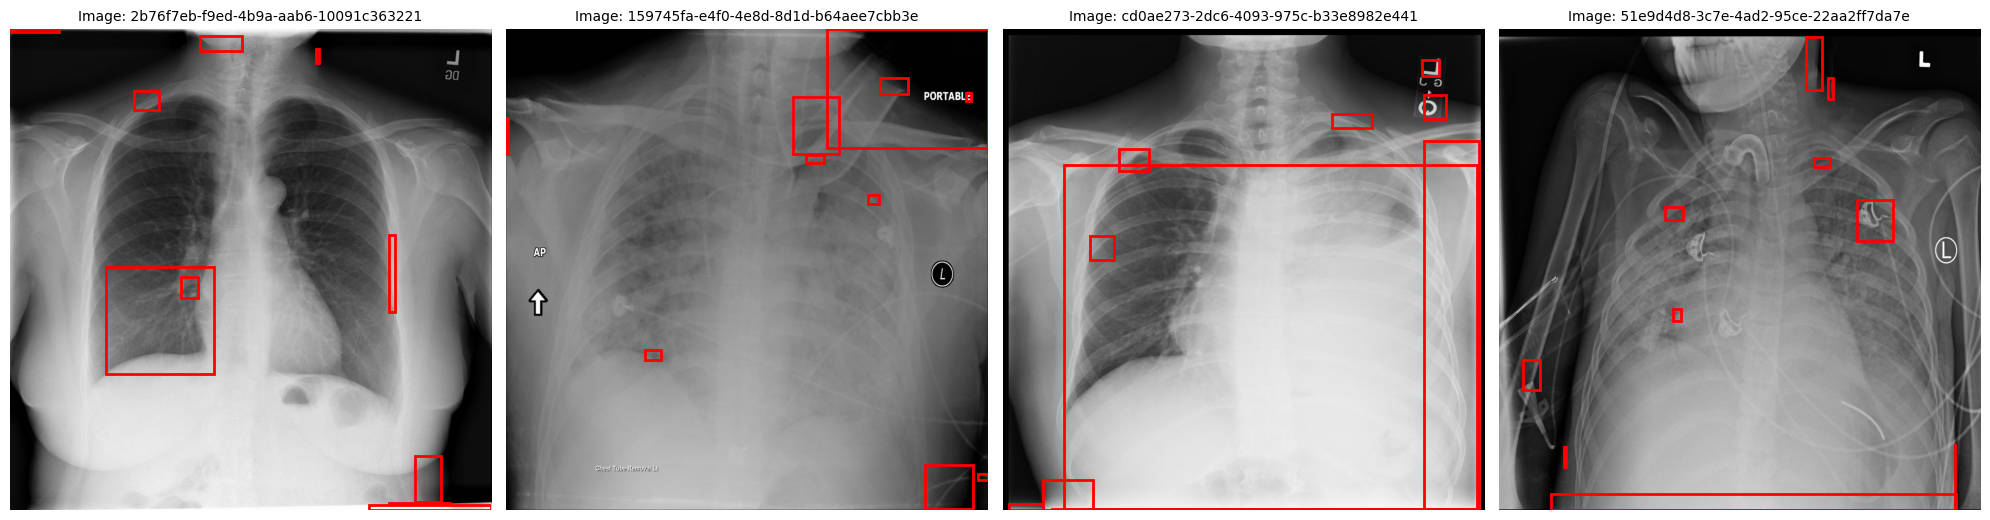

In [8]:
show_dicom_images_with_selective_search(train_dataset, train_image_path, num_images=4)

**Intersection over union**

Intersection over Union is simply an evaluation metric. Any algorithm that provides predicted bounding boxes as output can be evaluated using IoU.
More formally, in order to apply Intersection over Union to evaluate an (arbitrary) object detector we need:

1.The ground-truth bounding boxes (i.e., the hand labeled bounding boxes from the testing set that specify where in the image our object is).

2.The predicted bounding boxes from our model.
After getting these two we can find there intersection and union area,whih ultimately gives us our IoU.

In [9]:
def get_iou(bb1, bb2):
  # assuring for proper dimension.
    assert bb1['x1'] < bb1['x2']
    assert bb1['y1'] < bb1['y2']
    assert bb2['x1'] < bb2['x2']
    assert bb2['y1'] < bb2['y2']
  # calculating dimension of common area between these two boxes.
    x_left = max(bb1['x1'], bb2['x1'])
    y_top = max(bb1['y1'], bb2['y1'])
    x_right = min(bb1['x2'], bb2['x2'])
    y_bottom = min(bb1['y2'], bb2['y2'])
  # if there is no overlap output 0 as intersection area is zero.
    if x_right < x_left or y_bottom < y_top:
        return 0.0
  # calculating intersection area.
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
  # individual areas of both these bounding boxes.
    bb1_area = (bb1['x2'] - bb1['x1']) * (bb1['y2'] - bb1['y1'])
    bb2_area = (bb2['x2'] - bb2['x1']) * (bb2['y2'] - bb2['y1'])
  # union area = area of bb1_+ area of bb2 - intersection of bb1 and bb2.
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

**Preparing training data**

Training data here is prepared according to following scheme:-

a) Those boxes which have an IoU greater than 0.7 are considered as a positive example.

b) And boxes with relative low IoU 0.3 are taken to be negative examples.
Number of regions taken here is 10 positive and 10 negative of size 224x224. (Trying out with less number of regions datas due to large time and memory consumption)

In [10]:
# Optimized image processing using TensorFlow on GPU
def load_and_process_image(image_path, target_size=(224, 224)):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)  # Decode as RGB image
    image = tf.image.resize(image, target_size)
    image = image / 255.0  # Normalize image
    return image

# Function to calculate Intersection over Union (IoU)
def get_iou(box1, box2):
    x1, y1, x2, y2 = box1['x1'], box1['y1'], box1['x2'], box1['y2']
    x1_p, y1_p, x2_p, y2_p = box2['x1'], box2['y1'], box2['x2'], box2['y2']
    inter_area = max(0, min(x2, x2_p) - max(x1, x1_p)) * max(0, min(y2, y2_p) - max(y1, y1_p))
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x2_p - x1_p) * (y2_p - y1_p)
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Function to process image and generate training data
def process_image(row, img_path, num_positive, num_negative, max_regions):
    # Skip rows with NaN values or target != 1
    if pd.isna(row["x"]) or pd.isna(row["y"]) or pd.isna(row["width"]) or pd.isna(row["height"]) or row["Target"] != 1:
        return [], [], [], []

    full_img_path = os.path.join(img_path, f"{row['patientId'].split('/')[-1]}.jpg")

    # Check if the file exists
    if not os.path.exists(full_img_path):
        return [], [], [], []

    # Load and process image
    image = load_and_process_image(full_img_path)

    # Initialize variables for storing results
    pos_images, pos_labels, neg_images, neg_labels = [], [], [], []
    pos_counter, neg_counter = 0, 0

    # Example: Selective Search (or any other method for region proposals)
    # Here you would insert your code to generate region proposals, e.g., using Selective Search or EdgeBoxes

    # For demonstration, simulate positive/negative sample generation:
    for _ in range(min(max_regions, 100)):  # Limit to 100 regions
        if pos_counter < num_positive:
            pos_images.append(image)
            pos_labels.append(1)
            pos_counter += 1
        elif neg_counter < num_negative:
            neg_images.append(image)
            neg_labels.append(0)
            neg_counter += 1

    return pos_images, pos_labels, neg_images, neg_labels

# Function to prepare training data
def prepare_train_data(train_annotations, img_path, num_positive=10, num_negative=10, max_regions=100):
    train_images = []
    train_labels = []

    # Iterate over each row in the annotations
    for _, row in tqdm(train_annotations.iterrows(), total=len(train_annotations), desc="Processing images"):
        pos_images, pos_labels, neg_images, neg_labels = process_image(row, img_path, num_positive, num_negative, max_regions)
        train_images.extend(pos_images)
        train_labels.extend(pos_labels)
        train_images.extend(neg_images)
        train_labels.extend(neg_labels)

    return train_images, train_labels

In [11]:
train_images, train_labels = prepare_train_data(train_annotations.head(100), train_image_path)

Processing images: 100%|█████████████████████| 100/100 [00:00<00:00, 505.78it/s]


In [12]:
len(train_images)
len(train_labels)

980

In [13]:
import numpy as np
import h5py
from tqdm import tqdm

def save_batch_to_hdf5(images, labels, file_name):
    # Open HDF5 file in append mode
    with h5py.File(file_name, "a") as f:
        start_idx = f["images"].shape[0]  # Get the current size of the dataset
        f["images"].resize((start_idx + len(images),) + images.shape[1:])
        f["labels"].resize((start_idx + len(labels),))
        f["images"][start_idx:] = images
        f["labels"][start_idx:] = labels

def save_batches_sequentially(data_generator, file_name="train_data.h5"):
    # Prepare the HDF5 file
    with h5py.File(file_name, "w") as f:
        # Initialize datasets with max size for extendable arrays
        first_batch = next(data_generator)  # Get the first batch to infer dataset structure
        sample_images, sample_labels = np.array(first_batch[0]), np.array(first_batch[1])
        f.create_dataset("images", shape=(0,) + sample_images.shape[1:], maxshape=(None,) + sample_images.shape[1:], dtype=np.float32)
        f.create_dataset("labels", shape=(0,), maxshape=(None,), dtype=np.int32)

    # Reset the generator
    data_generator = iter(data_generator)  # Ensure we have a fresh iterator

    # Process and save data in batches
    for batch_images, batch_labels in tqdm(data_generator, desc="Saving batches", unit="batch"):
        save_batch_to_hdf5(np.array(batch_images), np.array(batch_labels), file_name)

# Generator function to yield batches of data
def data_generator(train_images, train_labels, batch_size):
    for i in range(0, len(train_images), batch_size):
        yield train_images[i:i + batch_size], train_labels[i:i + batch_size]

# Example usage
batch_size = 1000

# Pass an iterator to the saving function
gen = data_generator(train_images, train_labels, batch_size)
save_batches_sequentially(gen, file_name="train_data.h5")


Saving batches: 0batch [00:00, ?batch/s]


In [14]:
#importing required libraries
from keras import Model
from keras import optimizers

**Pre-training**

We perform tansfer-learning as pre-training here as we are using VGG16 net which is already trained on Imagenet. We are going to train a binary classifier by making all layers as untrainble except two last. And then we are going to make a new model which will be stacked on last 2nd output layer.

In [15]:
vgg = tf.keras.applications.vgg16.VGG16(include_top=True, weights='imagenet', input_tensor=None, input_shape=None, pooling=None, classes=1000)
for layer in vgg.layers[:-2]:
  layer.trainable = False
x = vgg.get_layer('fc2')
last_output =  x.output
x = tf.keras.layers.Dense(1,activation = 'sigmoid')(last_output)
model = tf.keras.Model(vgg.input,x)
model.compile(optimizer = "adam",
              loss = 'binary_crossentropy',
              metrics = ['acc'])

**Summary of the model and Training**

In [16]:
model.summary()

# Function to load a batch of images and labels from HDF5 file
def load_batch(file_name="train_data.h5", start_idx=0, batch_size=1000):
    with h5py.File(file_name, "r") as f:
        images = f["images"][start_idx:start_idx + batch_size]
        labels = f["labels"][start_idx:start_idx + batch_size]
    return images, labels

# Training loop with batch loading
def train_model_in_batches(model, file_name="train_data.h5", batch_size=32, epochs=3):
    # Get the total number of samples from HDF5
    with h5py.File(file_name, "r") as f:
        num_samples = len(f["images"])

    steps_per_epoch = num_samples // batch_size

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Shuffle index for each epoch to prevent model from seeing data in the same order
        indices = np.arange(num_samples)
        np.random.shuffle(indices)

        # Train on each batch
        for step in range(steps_per_epoch):
            start_idx = indices[step * batch_size]
            images, labels = load_batch(file_name=file_name, start_idx=start_idx, batch_size=batch_size)

            # Train on the batch
            model.train_on_batch(images, labels)

        print(f"Epoch {epoch+1} completed.")

# Example usage:
train_model_in_batches(model, file_name="train_data.h5", batch_size=32, epochs=3)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │         4,097 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,264,641 (512.18 MB)

 Trainable params: 16,785,409 (64.03 MB)

 Non-trainable params: 117,479,232 (448.15 MB)

Epoch 1/3
Epoch 1 completed.
Epoch 2/3
Epoch 2 completed.
Epoch 3/3
Epoch 3 completed.


**Making New Network with svm**

We will start with first creating the dataset for the svm and will then go for the architecture

In [18]:
def process_images_for_svm(train_annotations, train_dicom_path, svm_image, svm_label, get_iou):
    """
    Processes images for SVM training, extracting positive and negative samples using Selective Search.

    Parameters:
        train_annotations (DataFrame): DataFrame containing patient IDs and bounding box annotations.
        train_dicom_path (str): Path to the folder containing DICOM files.
        svm_image (list): List to store extracted image samples for SVM.
        svm_label (list): List to store labels corresponding to image samples.
        get_iou (function): Function to calculate Intersection over Union (IoU).

    Returns:
        None
    """
    
    for index, row in tqdm(train_annotations.iterrows(), total=len(train_annotations), desc="Processing Images"):
        try:
            # Skip rows with NaN bounding box values
            if pd.isna(row["x"]) or pd.isna(row["y"]) or pd.isna(row["width"]) or pd.isna(row["height"]):
                continue

            dicom_path = os.path.join(train_dicom_path, f"{row['patientId']}.jpg")
            image = Image.open(dicom_path).convert("RGB")

            # Normalize image to range 0-255
            normalized_image = np.array(image)
            normalized_image = (normalized_image - np.min(normalized_image)) / (np.max(normalized_image) - np.min(normalized_image)) * 255
            normalized_image = normalized_image.astype(np.uint8)

            # Ground truth bounding box
            gt_box = {
                "x1": int(row["x"]),
                "y1": int(row["y"]),
                "x2": int(row["x"] + row["width"]),
                "y2": int(row["y"] + row["height"])
            }

            # Extract ground truth region for positive samples
            timage = normalized_image[gt_box["y1"]:gt_box["y2"], gt_box["x1"]:gt_box["x2"]]
            resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
            svm_image.append(resized)
            svm_label.append([0, 1])  # Positive label

            # Set up Selective Search
            ss.setBaseImage(normalized_image)
            ss.switchToSelectiveSearchFast()
            ssresults = ss.process()

            falsecounter = 0
            for result in ssresults[:2000]:  # Limit to top 2000 proposals
                x, y, w, h = result
                proposed_box = {"x1": x, "y1": y, "x2": x + w, "y2": y + h}
                iou = get_iou(gt_box, proposed_box)

                # Add negative samples for low IoU proposals
                if falsecounter < 5 and iou < 0.3:
                    timage = normalized_image[y:y + h, x:x + w]
                    resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
                    svm_image.append(resized)
                    svm_label.append([1, 0])  # Negative label
                    falsecounter += 1

                # Stop once sufficient negatives are collected
                if falsecounter >= 5:
                    break

        except Exception as e:
            print(f"Error processing patient ID {row['patientId']}: {e}")
            continue

In [19]:
svm_image = []
svm_label = []


process_images_for_svm(
    train_annotations=train_annotations.head(1000),
    train_dicom_path=train_image_path,
    svm_image=svm_image,
    svm_label=svm_label,
    get_iou=get_iou
)

Processing Images: 100%|████████████████████| 1000/1000 [31:15<00:00,  1.88s/it]


**SVM Model Architecture**

First we removed the last layer of the previous model and then added a Dense layer of 2 units at the end.

Now we will see our new Model Summary and we will train it.

In [21]:
# Adding SVM as the final layer
x = model.get_layer('fc2').output
y = tf.keras.layers.Dense(2)(x)  # Output layer with 2 units for binary classification
final_model = tf.keras.Model(inputs=model.input, outputs=y)  # Define the final model
final_model.compile(loss='hinge',  # SVM loss function
                    optimizer='adam',  # Adam optimizer
                    metrics=['accuracy'])  # Accuracy metric

# Display the model summary
final_model.summary()

# Load pre-trained weights into the model
#final_model.load_weights('my_model_weights.h5')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         8,194 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,268,738 (512.19 MB)

 Trainable params: 16,789,506 (64.05 MB)

 Non-trainable params: 117,479,232 (448.15 MB)

In [22]:
hist_final = final_model.fit(np.array(svm_image),np.array(svm_label),batch_size=32,epochs = 20,verbose = 1,shuffle = True,validation_split = 0.05)

Epoch 1/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8909 - loss: 2.4442 - val_accuracy: 0.9767 - val_loss: 0.3391
Epoch 2/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 123s 2s/step - accuracy: 0.9729 - loss: 0.3737 - val_accuracy: 0.9845 - val_loss: 0.2425
Epoch 3/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9704 - loss: 0.2204 - val_accuracy: 0.9767 - val_loss: 0.2040
Epoch 4/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9784 - loss: 0.1209 - val_accuracy: 0.9845 - val_loss: 0.1249
Epoch 5/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9845 - loss: 0.0752 - val_accuracy: 0.9922 - val_loss: 0.0313
Epoch 6/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9830 - loss: 0.0756 - val_accuracy: 0.9922 - val_loss: 0.0457
Epoch 7/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 125s 2s/step - accuracy: 0.9943 - loss: 0.0230 - val_accuracy: 0.9690 - val_loss: 0.0961
Epoch 8/20
77/77 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.9887 - loss: 0.0255 - val_accuracy: 0.9845 - v

**Ploting loss and analysing losses**

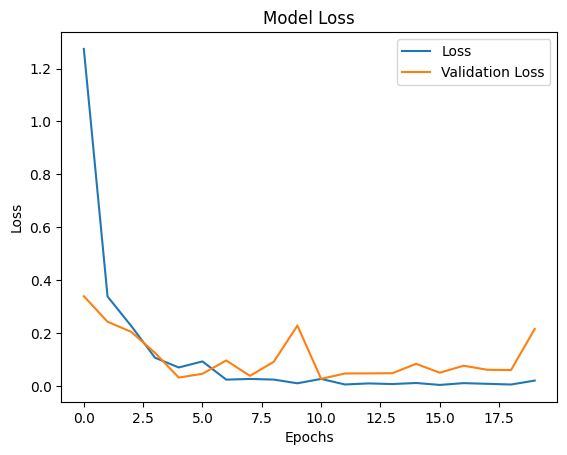

<Figure size 640x480 with 0 Axes>

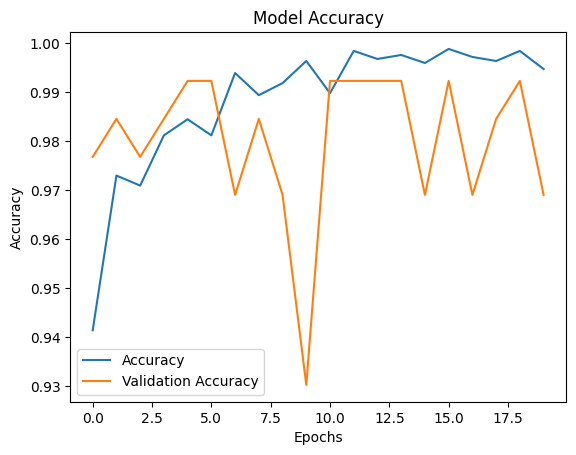

<Figure size 640x480 with 0 Axes>

In [25]:
# Plotting Loss
plt.figure()  # Create a new figure for the loss plot
plt.plot(hist_final.history['loss'], label='Loss')
plt.plot(hist_final.history['val_loss'], label='Validation Loss')

# Adding title and labels to the plot
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epochs")

# Displaying the legend
plt.legend()

# Showing the plot
plt.show()

# Saving the plot as an image
plt.savefig('chart_loss.png')


# Plotting Accuracy
plt.figure()  # Create a new figure for the accuracy plot
plt.plot(hist_final.history['accuracy'], label='Accuracy')
plt.plot(hist_final.history['val_accuracy'], label='Validation Accuracy')

# Adding title and labels to the plot
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")

# Displaying the legend
plt.legend()

# Showing the plot
plt.show()

# Saving the plot as an image
plt.savefig('chart_accuracy.png')

**Test Time**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step
Proposal 0, Prediction: [[     24.707     -28.031]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
Proposal 1, Prediction: [[     20.893     -22.065]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Proposal 2, Prediction: [[      25.55     -27.575]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Proposal 3, Prediction: [[      16.87     -17.936]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Proposal 4, Prediction: [[     18.137      -19.58]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Proposal 5, Prediction: [[     24.003     -26.545]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Proposal 6, Prediction: [[     20.582     -24.428]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
Proposal 7, Prediction: [[     45.067     -46.901]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Proposal 8, Prediction: [[     27.204      -28.45]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Proposal 9, Prediction: [[     30.451     -31.757]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Proposal 10, Prediction: [[     9.2968     -10.036]]
1/1 ━━━━

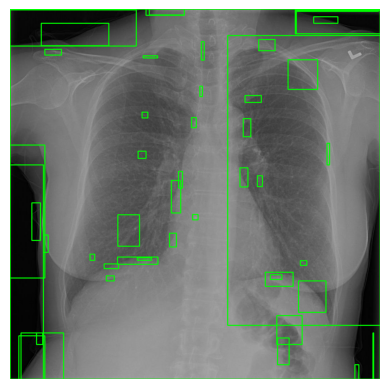

In [26]:
# Define the path to the test images
test_path = 'Dataset/test_images/'

# Get the list of test images
test_files = os.listdir(test_path)

# Ensure there are files in the directory
if not test_files:
    raise ValueError("No files found in the test directory!")

# Load the first test image
image = cv2.imread(os.path.join(test_path, test_files[0]))

# Set up Selective Search
ss.setBaseImage(image)
ss.switchToSelectiveSearchFast()
ssresults = ss.process()

# Initialize image for visualization
imOut = image.copy()
detected_count = 0

# Process the top 50 proposals
for e, result in enumerate(ssresults[:50]):  # Limit to top 50 proposals
    x, y, w, h = result

    # Extract and resize region proposal
    timage = imOut[y:y+h, x:x+w]
    resized = cv2.resize(timage, (224, 224), interpolation=cv2.INTER_AREA)
    resized = np.expand_dims(resized, axis=0)

    # Predict using the trained model
    prediction = final_model.predict(resized)
    print(f"Proposal {e}, Prediction: {prediction}")

    # If prediction indicates object, add bounding box
    if prediction[0][0] > 0.5:  # Threshold for positive detection
        cv2.rectangle(imOut, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Draw bounding box
        detected_count += 1

# Display results
print(f"Total objects detected: {detected_count}")
plt.imshow(cv2.cvtColor(imOut, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

#### YOLO for Object Detection

Create working folders for images and labels for yolo model training

In [ ]:
try:
    shutil.rmtree('/content/drive/MyDrive/Working/')
except:
    pass

In [ ]:
CSV_FILE = '/content/drive/MyDrive/Dataset/stage_2_train_labels.csv'
TRAIN_SRC_DIR = '/content/drive/MyDrive/Dataset/train_images/'
TEST_SRC_DIR = '/content/drive/MyDrive/Dataset/test_images/'
DATASET_DIR = '/content/drive/MyDrive/Working/'
TEST_IMG_DIR = '/content/drive/MyDrive/Working/test/'

os.mkdir(DATASET_DIR)
os.mkdir(DATASET_DIR + 'images/')
os.mkdir(DATASET_DIR + 'images/train/')
os.mkdir(DATASET_DIR + 'images/val/')
os.mkdir(DATASET_DIR + 'images/test/')
os.mkdir(DATASET_DIR + 'labels/')
os.mkdir(DATASET_DIR + 'labels/train/')
os.mkdir(DATASET_DIR + 'labels/val/')
os.mkdir(DATASET_DIR + 'labels/test/')
os.mkdir(TEST_IMG_DIR)

In [ ]:
annotations = pd.read_csv(CSV_FILE)
print(annotations.info())
annotations.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 1.4+ MB
None


patientId      x      y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6    NaN    NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd    NaN    NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb    NaN    NaN    NaN     NaN       0
3  003d8fa0-6bf1-40ed-b54c-ac657f8495c5    NaN    NaN    NaN     NaN       0
4  00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1

In [ ]:
positive_annotations = annotations[annotations.Target == 1]
negative_annotations = annotations[annotations.Target == 0]

print(positive_annotations['patientId'].drop_duplicates().shape[0])
print(negative_annotations['patientId'].drop_duplicates().shape[0])
print(negative_annotations['patientId'].shape[0])

negative_sample = negative_annotations.sample(600)
negative_sample['patientId'].shape[0]

annotations = pd.concat([positive_annotations, negative_sample])
print(annotations.shape)
annotations.head()

6012
20672
20672
(10155, 6)


patientId      x      y  width  height  Target
4   00436515-870c-4b36-a041-de91049b9ab4  264.0  152.0  213.0   379.0       1
5   00436515-870c-4b36-a041-de91049b9ab4  562.0  152.0  256.0   453.0       1
8   00704310-78a8-4b38-8475-49f4573b2dbb  323.0  577.0  160.0   104.0       1
9   00704310-78a8-4b38-8475-49f4573b2dbb  695.0  575.0  162.0   137.0       1
14  00aecb01-a116-45a2-956c-08d2fa55433f  288.0  322.0   94.0   135.0       1

In [ ]:
patient_id_series = annotations.patientId.drop_duplicates()
print('Number of images:', patient_id_series.size)

train_series, val_series = train_test_split(patient_id_series, test_size=0.1, random_state=42)
print('Train set number:', len(train_series))
print('Validation set number:', len(val_series))

Number of images: 6612
Train set number: 5950
Validation set number: 662


Extract images and store in the train and validation folders

In [ ]:
import os
from tqdm import tqdm
import shutil


TRAIN_DEST_DIR = DATASET_DIR + 'images/train/'  # Destination directory to move images
VAL_DEST_DIR = DATASET_DIR + 'images/val/'  # Destination directory to move images

# Move images
for patient_id in tqdm(train_series, desc="Moving images", unit="image"):
    src_path = os.path.join(TRAIN_SRC_DIR, patient_id + '.jpg')
    dest_path = os.path.join(TRAIN_DEST_DIR, patient_id + '.jpg')
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)  # Move the file
    else:
        print(f"File not found: {src_path}")

# Count the number of moved images
moved_count = len(os.listdir(TRAIN_DEST_DIR))
print(f'Images moved to destination folder: {moved_count}')

# Move images
for patient_id in tqdm(val_series, desc="Moving images", unit="image"):
    src_path = os.path.join(TRAIN_SRC_DIR, patient_id + '.jpg')
    dest_path = os.path.join(VAL_DEST_DIR, patient_id + '.jpg')
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)  # Move the file
    else:
        print(f"File not found: {src_path}")

# Count the number of moved images
moved_count = len(os.listdir(VAL_DEST_DIR))
print(f'Images moved to destination folder: {moved_count}')

Moving images: 100%|██████████| 5950/5950 [00:18<00:00, 313.43image/s]


Images moved to destination folder: 5950


Moving images: 100%|██████████| 662/662 [00:01<00:00, 337.30image/s]

Images moved to destination folder: 662


Prepare test dataset

In [ ]:
# Move images
for file in tqdm(os.listdir(TEST_SRC_DIR), desc="Moving images", unit="image"):
    src_path = TEST_SRC_DIR + file
    dest_path = os.path.join(TEST_IMG_DIR, os.path.splitext(file)[0] + '.jpg')
    if os.path.exists(src_path):
        shutil.move(src_path, dest_path)  # Move the file
    else:
        print(f"File not found: {src_path}")

# Count the number of moved images
moved_count = len(os.listdir(TEST_IMG_DIR))
print(f'Images moved to destination folder: {moved_count}')

Moving images: 100%|██████████| 3000/3000 [00:08<00:00, 356.92image/s]

Images moved to destination folder: 3000


In [ ]:
def translate_bbox(bbox):
    img_size = 1024 # rsna defualt image size

    top_left_x = bbox[0]
    top_left_y = bbox[1]
    absolute_w = bbox[2]
    absolute_h = bbox[3]

    relative_w = absolute_w / img_size
    relative_h = absolute_h / img_size

    relative_x = top_left_x / img_size + relative_w / 2
    relative_y = top_left_y / img_size + relative_h / 2

    return relative_x, relative_y, relative_w, relative_h

def revert_bbox(rx, ry, rw, rh):
    img_size = 1024 # rsna defualt image size

    x = (rx-rw/2)*img_size
    y = (ry-rh/2)*img_size
    w = rw*img_size
    h = rh*img_size

    return x, y, w, h


def save_label(label_dir, patient_id, bbox):
    label_fp = os.path.join(label_dir, patient_id + '.txt')

    f = open(label_fp, "a")
    if (bbox == 'nan').all():
        f.close()
        return

    x, y, w, h = translate_bbox(bbox)

    line = f"0 {x} {y} {w} {h}\n"

    f.write(line)
    f.close()

In [ ]:
LABELS_DIR = "/content/drive/MyDrive/Working/labels_temp/"
os.mkdir(LABELS_DIR)

for row in annotations.values:
    if pd.notna(row[1:5]).all():
        save_label(LABELS_DIR, row[0], row[1:5])

for patient_id in train_series:
    if os.path.isfile(LABELS_DIR + patient_id + '.txt'):
        shutil.copy(LABELS_DIR + patient_id + '.txt', DATASET_DIR + 'labels/train/')

for patient_id in val_series:
    if os.path.isfile(LABELS_DIR + patient_id + '.txt'):
        shutil.copy(LABELS_DIR + patient_id + '.txt', DATASET_DIR + 'labels/val/')

shutil.rmtree(LABELS_DIR)

Display example from dataset with bounding box

0 0.7412109375 0.49658203125 0.162109375 0.0966796875



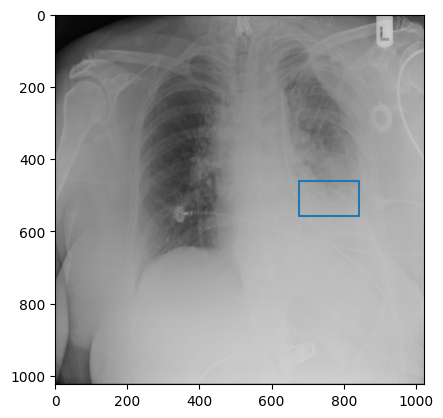

In [ ]:
demo_patient_id = val_series.values[8]
demo_img_path = DATASET_DIR + 'images/val/' + demo_patient_id + '.jpg'
demo_label_path = DATASET_DIR + 'labels/val/' + demo_patient_id + '.txt'

plt.imshow(cv2.imread(demo_img_path))

with open(demo_label_path, "r") as f:
    for line in f:
        print(line)
        class_id, rx, ry, rw, rh = list(map(float, line.strip().split()))

        x, y, w, h = revert_bbox(rx, ry, rw, rh)
        plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y])

Prepare configuration and run training

In [ ]:
%%writefile /content/drive/MyDrive/Working/config.yaml

path: '/content/drive/MyDrive/Working' # dataset root dir
train: images/train  # train images (relative to 'path')
val: images/val  # val images (relative to 'path')

# Classes
names:
  0: pneumonia

Writing /content/drive/MyDrive/Working/config.yaml


In [ ]:
model = YOLO('yolov8l.pt') # yaml

100%|██████████| 83.7M/83.7M [00:00<00:00, 356MB/s]


In [ ]:
wandb.login(key='da27b138f0f392e3f931cf71acdab08543ac649c')
results = model.train(data='/content/drive/MyDrive/Working/config.yaml', epochs=20)

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Ultralytics 8.3.52 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
engine/trainer: task=detect, mode=train, model=yolov8l.pt, data=/content/drive/MyDrive/Working/config.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=Tru

100%|██████████| 755k/755k [00:00<00:00, 21.7MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1      1856  ultralytics.nn.modules.conv.Conv             [3, 64, 3, 2]                 
  1                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  2                  -1  3    279808  ultralytics.nn.modules.block.C2f             [128, 128, 3, True]           
  3                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  4                  -1  6   2101248  ultralytics.nn.modules.block.C2f             [256, 256, 6, True]           


  5                  -1  1   1180672  ultralytics.nn.modules.conv.Conv             [256, 512, 3, 2]              
  6                  -1  6   8396800  ultralytics.nn.modules.block.C2f             [512, 512, 6, True]           
  7                  -1  1   2360320  ultralytics.nn.modules.conv.Conv             [512, 512, 3, 2]              
  8                  -1  3   4461568  ultralytics.nn.modules.block.C2f             [512, 512, 3, True]           
  9                  -1  1    656896  ultralytics.nn.modules.block.SPPF            [512, 512, 5]                 
 10                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None, 2, 'nearest']          
 11             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 12                  -1  3   4723712  ultralytics.nn.modules.block.C2f             [1024, 512, 3]                
 13                  -1  1         0  torch.nn.modules.upsampling.Upsample         [None

100%|██████████| 5.35M/5.35M [00:00<00:00, 97.2MB/s]


AMP: checks passed ✅


train: Scanning /content/drive/MyDrive/Working/labels/train... 5405 images, 545 backgrounds, 0 corrupt: 100%|██████████| 5950/5950 [01:28<00:00, 67.25it/s] 


train: New cache created: /content/drive/MyDrive/Working/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/drive/MyDrive/Working/labels/val... 607 images, 55 backgrounds, 0 corrupt: 100%|██████████| 662/662 [00:04<00:00, 164.64it/s]


val: New cache created: /content/drive/MyDrive/Working/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 97 weight(decay=0.0), 104 weight(decay=0.0005), 103 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      10.4G      2.119      2.607      2.223         28        640: 100%|██████████| 372/372 [01:11<00:00,  5.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:05<00:00,  3.88it/s]

                   all        662        962       0.19      0.277      0.117     0.0333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      10.4G      2.088      2.389      2.116         34        640: 100%|██████████| 372/372 [01:07<00:00,  5.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  6.21it/s]

                   all        662        962     0.0501      0.166     0.0357     0.0119



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      10.3G      2.053      2.286      2.068         33        640: 100%|██████████| 372/372 [01:05<00:00,  5.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.83it/s]


                   all        662        962       0.31      0.375      0.232      0.067

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      10.5G      1.992      2.212      2.021         34        640: 100%|██████████| 372/372 [01:04<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.00it/s]

                   all        662        962      0.395      0.384      0.337      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      10.5G      1.932      2.147      1.932         40        640: 100%|██████████| 372/372 [01:04<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.17it/s]

                   all        662        962      0.407      0.445       0.37      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      10.5G      1.938      2.095       1.93         27        640: 100%|██████████| 372/372 [01:04<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.33it/s]

                   all        662        962      0.483      0.454      0.431      0.147



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      10.5G      1.896      2.048        1.9         39        640: 100%|██████████| 372/372 [01:04<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03<00:00,  5.30it/s]

                   all        662        962      0.244      0.113     0.0751     0.0218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      10.5G      1.879      2.011      1.883         38        640: 100%|██████████| 372/372 [01:04<00:00,  5.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]

                   all        662        962       0.48      0.485      0.444      0.156



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      10.5G      1.874      1.992      1.875         27        640: 100%|██████████| 372/372 [01:04<00:00,  5.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.12it/s]

                   all        662        962      0.508      0.526      0.488      0.183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      10.5G      1.839      1.935      1.851         43        640: 100%|██████████| 372/372 [01:04<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.84it/s]

                   all        662        962      0.444      0.519      0.467      0.176


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      10.5G      1.948      1.922      1.952         24        640: 100%|██████████| 372/372 [01:06<00:00,  5.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.17it/s]

                   all        662        962      0.516      0.511      0.495      0.186



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      10.5G      1.932      1.901       1.94         18        640: 100%|██████████| 372/372 [01:04<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.04it/s]

                   all        662        962      0.423      0.504      0.414      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      10.5G      1.907      1.866      1.925         16        640: 100%|██████████| 372/372 [01:04<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.81it/s]

                   all        662        962      0.485      0.505      0.446      0.171



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      10.5G      1.892      1.855      1.916         17        640: 100%|██████████| 372/372 [01:04<00:00,  5.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.21it/s]

                   all        662        962      0.535       0.52      0.509       0.19



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      10.5G      1.874      1.841      1.901         18        640: 100%|██████████| 372/372 [01:04<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.19it/s]

                   all        662        962      0.471      0.481      0.434      0.157



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      10.5G      1.868      1.786      1.885         21        640: 100%|██████████| 372/372 [01:04<00:00,  5.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.05it/s]

                   all        662        962      0.385      0.374      0.315      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      10.5G      1.855      1.777      1.877         21        640: 100%|██████████| 372/372 [01:04<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.87it/s]

                   all        662        962      0.441      0.459      0.411      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      10.5G      1.831      1.757      1.852         23        640: 100%|██████████| 372/372 [01:05<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.09it/s]

                   all        662        962      0.513      0.541      0.498      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      10.5G       1.82      1.737      1.843         21        640: 100%|██████████| 372/372 [01:05<00:00,  5.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.14it/s]

                   all        662        962      0.505      0.538      0.492      0.201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      10.5G      1.804      1.712      1.824         22        640: 100%|██████████| 372/372 [01:05<00:00,  5.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  5.04it/s]

                   all        662        962      0.508      0.579      0.527      0.218



20 epochs completed in 0.399 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 87.6MB
Optimizer stripped from runs/detect/train/weights/best.pt, 87.6MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.52 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 268 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:04<00:00,  4.26it/s]


                   all        662        962      0.503      0.579      0.526      0.218
Speed: 0.1ms preprocess, 2.4ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


In [ ]:
import matplotlib.image as mpimg

# Load the trained YOLOv8 model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Validate the model on the validation dataset
results = model.val(data='/content/drive/MyDrive/Working/config.yaml')


Ultralytics 8.3.52 🚀 Python-3.10.12 torch-2.5.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)
Model summary (fused): 268 layers, 43,607,379 parameters, 0 gradients, 164.8 GFLOPs


val: Scanning /content/drive/MyDrive/Working/labels/val.cache... 607 images, 55 backgrounds, 0 corrupt: 100%|██████████| 662/662 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 42/42 [00:09<00:00,  4.29it/s]


                   all        662        962      0.505       0.58      0.527      0.218
Speed: 0.2ms preprocess, 4.1ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/val14


In [ ]:
# Access and print metrics from the validation results
print(f"Precision: {results.box.p.mean():.2f}")
print(f"Recall: {results.box.r.mean():.2f}")
print(f"F1 Score: {results.box.f1.mean():.2f}")

Precision: 0.51
Recall: 0.58
F1 Score: 0.54


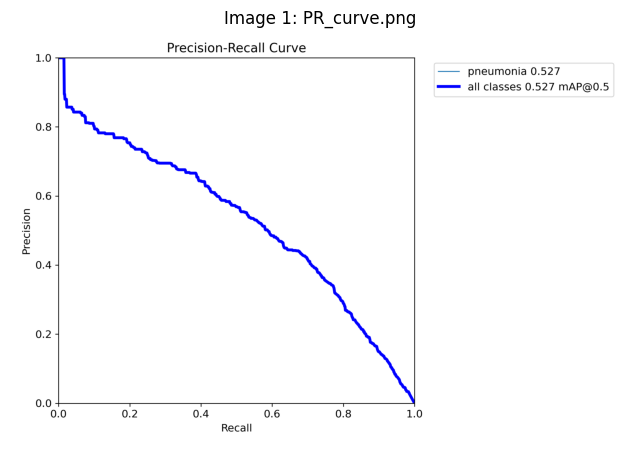

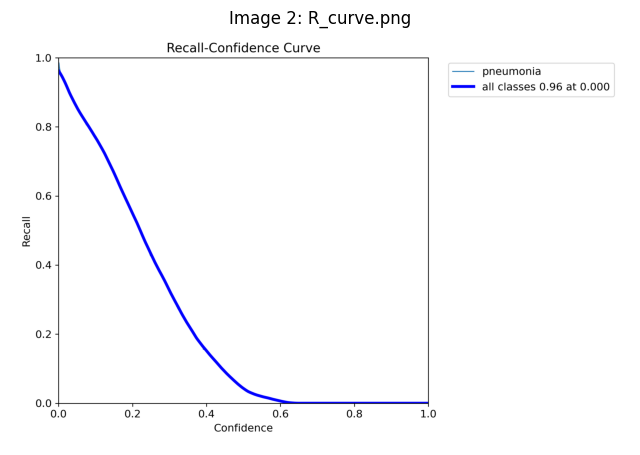

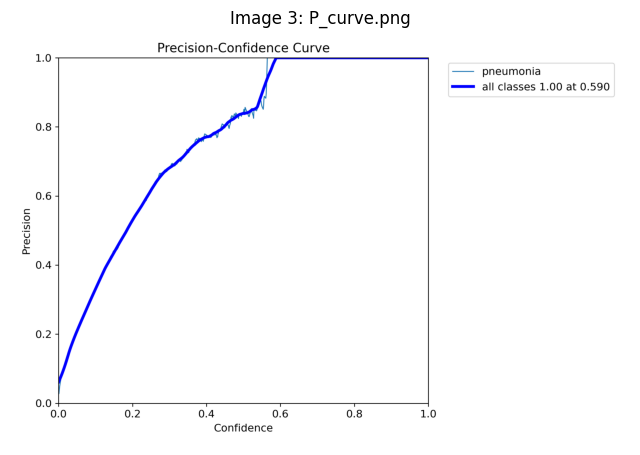

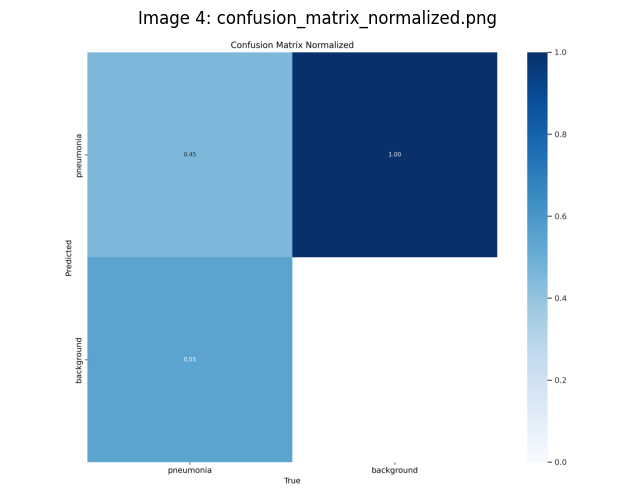

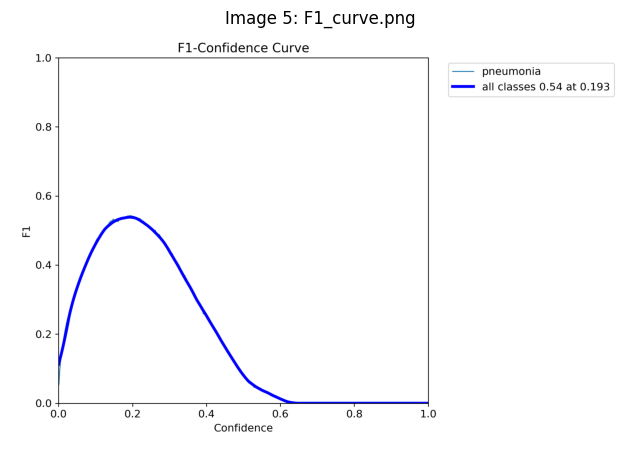

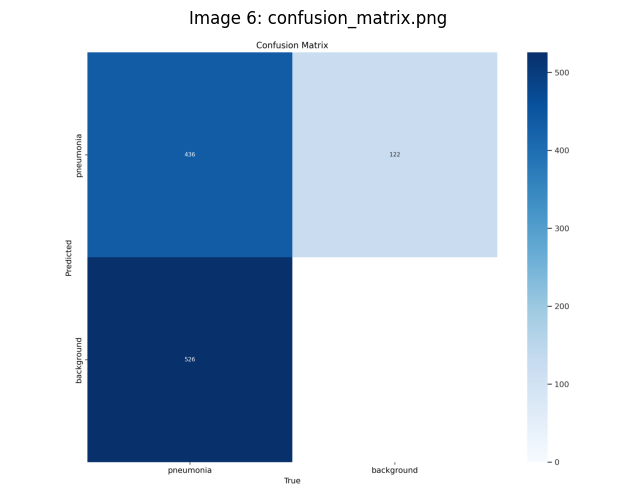

In [ ]:
# Define the directory where the images are stored
val_folder = '/content/runs/detect/val14'

# List all PNG files in the folder
png_files = [f for f in os.listdir(val_folder) if f.endswith('.png')]

# Check if there are any PNG files
if not png_files:
    print("No PNG files found in the folder.")
else:
    # Loop through each PNG file and display it
    for i, png_file in enumerate(png_files):
        img_path = os.path.join(val_folder, png_file)
        img = mpimg.imread(img_path)

        # Create a new figure for each image
        plt.figure(figsize=(8, 6))
        plt.imshow(img)
        plt.axis('off')  # Hide axis for a clean display
        plt.title(f"Image {i + 1}: {png_file}")
        plt.show()

In [ ]:
# Load the trained YOLOv8 model
model = YOLO('/content/runs/detect/train/weights/best.pt')

# Save the model using pickle
with open('/content/drive/MyDrive/Dataset/yolov8_model.pkl', 'wb') as f:
    pickle.dump(model, f)

print("Model has been pickled and saved as 'yolov8_model.pkl'")

Model has been pickled and saved as 'yolov8_model.pkl'


Inspect model predictions

In [ ]:
def plot_val_pred(demo_patient_id, verbose=True, split='val'):
    demo_img_path = DATASET_DIR + f'images/{split}/' + demo_patient_id + '.jpg'
    demo_label_path = DATASET_DIR + f'labels/{split}/' + demo_patient_id + '.txt'

    res = model(demo_img_path, verbose=verbose)
    if verbose:
        print(res[0].probs)
        print(res[0].boxes.xywh)

    plt.imshow(cv2.imread(demo_img_path))

    img_size = 1014
    if os.path.isfile(demo_label_path):
        with open(demo_label_path, "r") as f:
            for line in f:
                if verbose:
                    print(line)
                class_id, rx, ry, rw, rh = list(map(float, line.strip().split()))

                x, y, w, h = revert_bbox(rx, ry, rw, rh)
                plt.plot([x, x, x+w, x+w, x], [y, y+h, y+h, y, y], c='blue')


    for box in res[0].boxes.xywh.cpu():
        px, py, pw, ph = box
        plt.plot([px-pw/2, px-pw/2, px+pw/2, px+pw/2, px-pw/2], [py-ph/2, py+ph/2, py+ph/2, py-ph/2, py-ph/2], c='orange')

<Figure size 640x480 with 0 Axes>

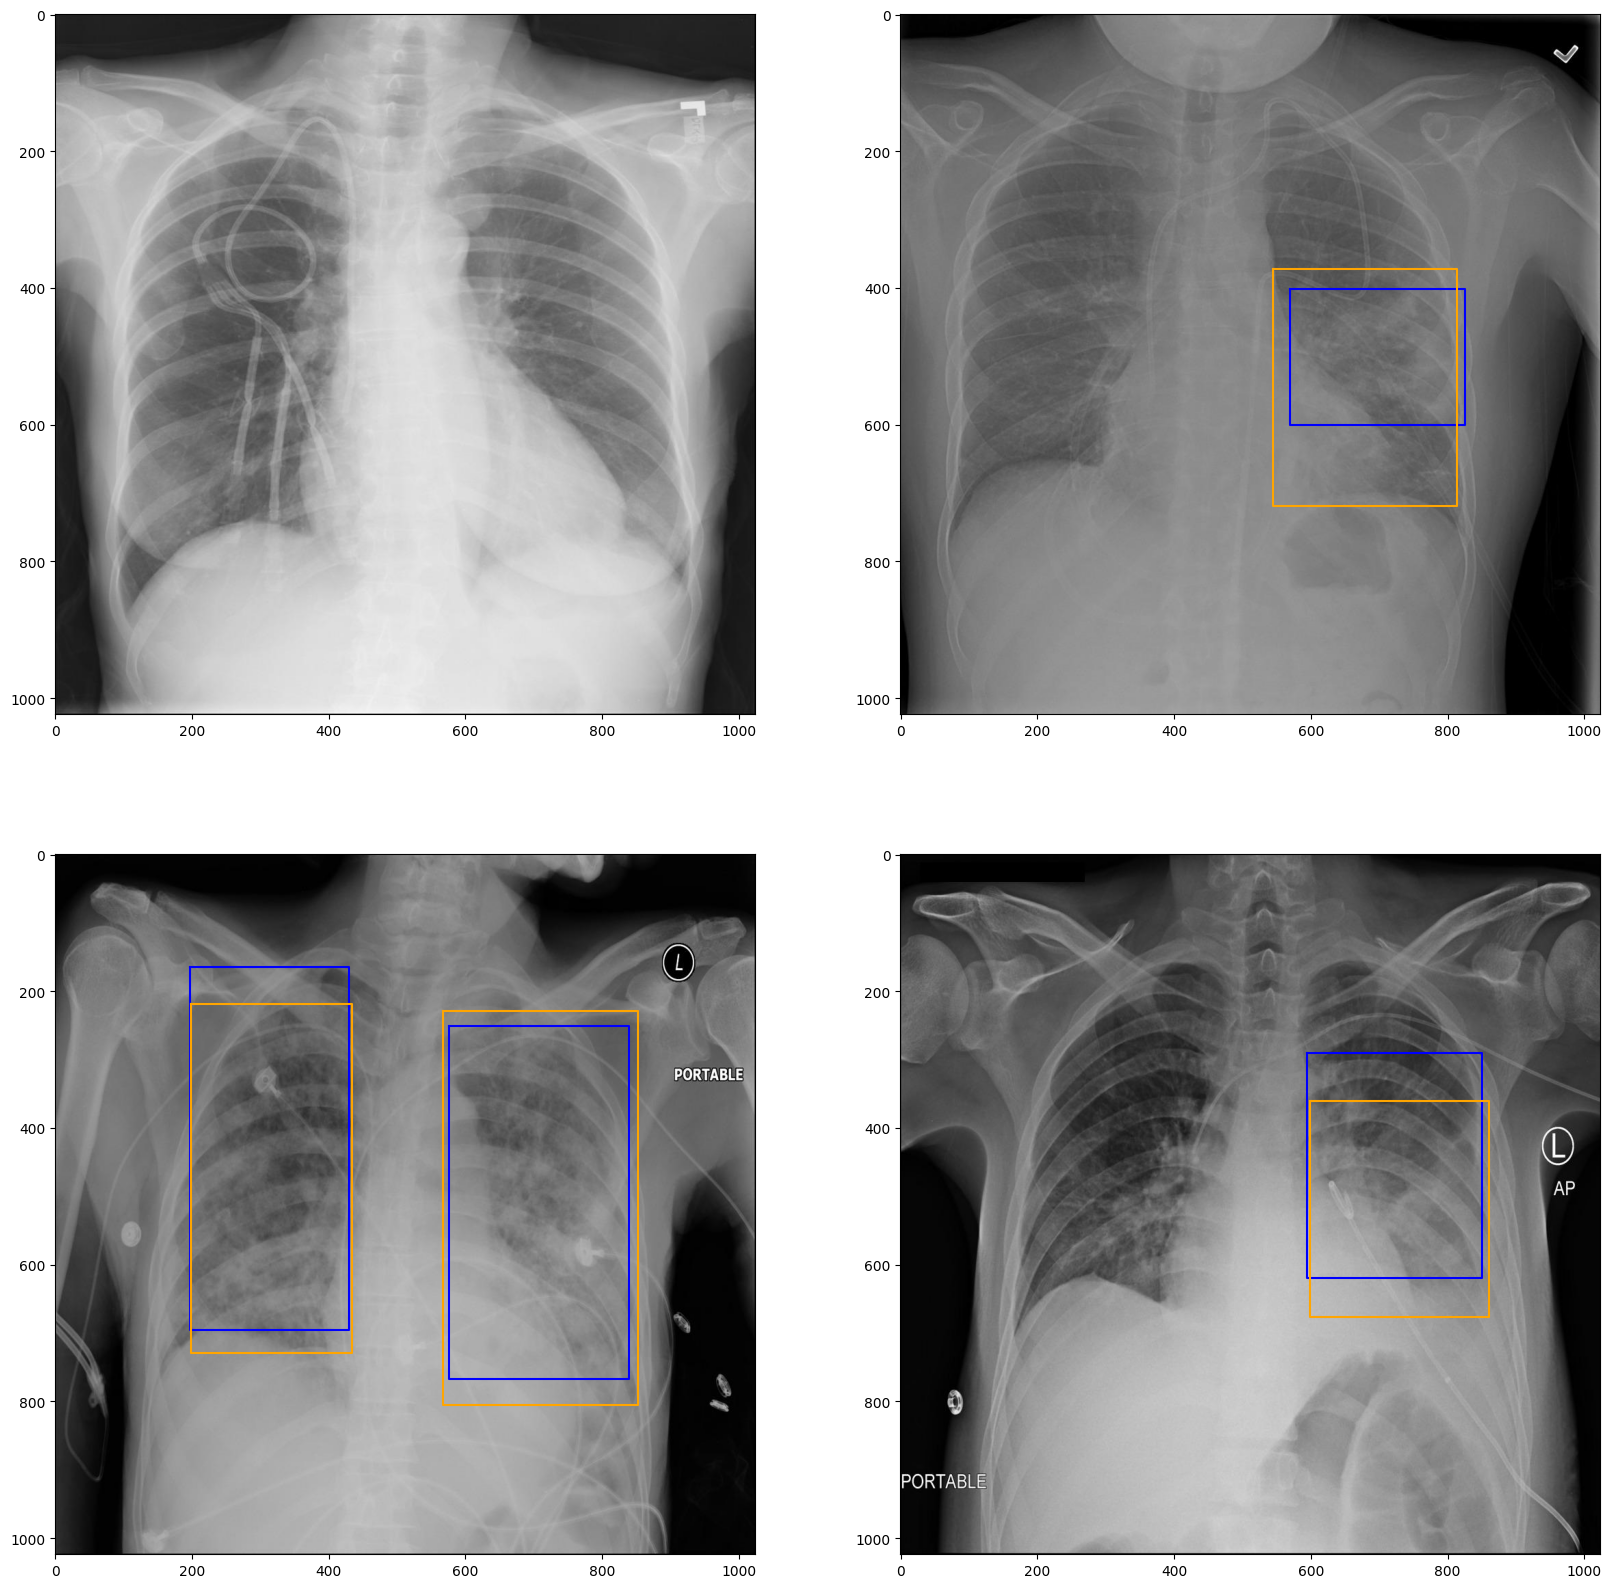

In [ ]:
def random_value(series):
    return series.iloc[random.randrange(0, len(series))]

def plot_examples(series, rows = 5, cols = 2, split='val'):
    plt.suptitle(split)
    plt.figure(figsize=(10*cols,10*rows))
    for h in range(rows):
        for w in range(cols):
            plt.subplot(rows, cols, h*2+w+1)
            plot_val_pred(random_value(series), verbose=False, split=split)

plot_examples(train_series, 2, 2, 'train')

<Figure size 640x480 with 0 Axes>

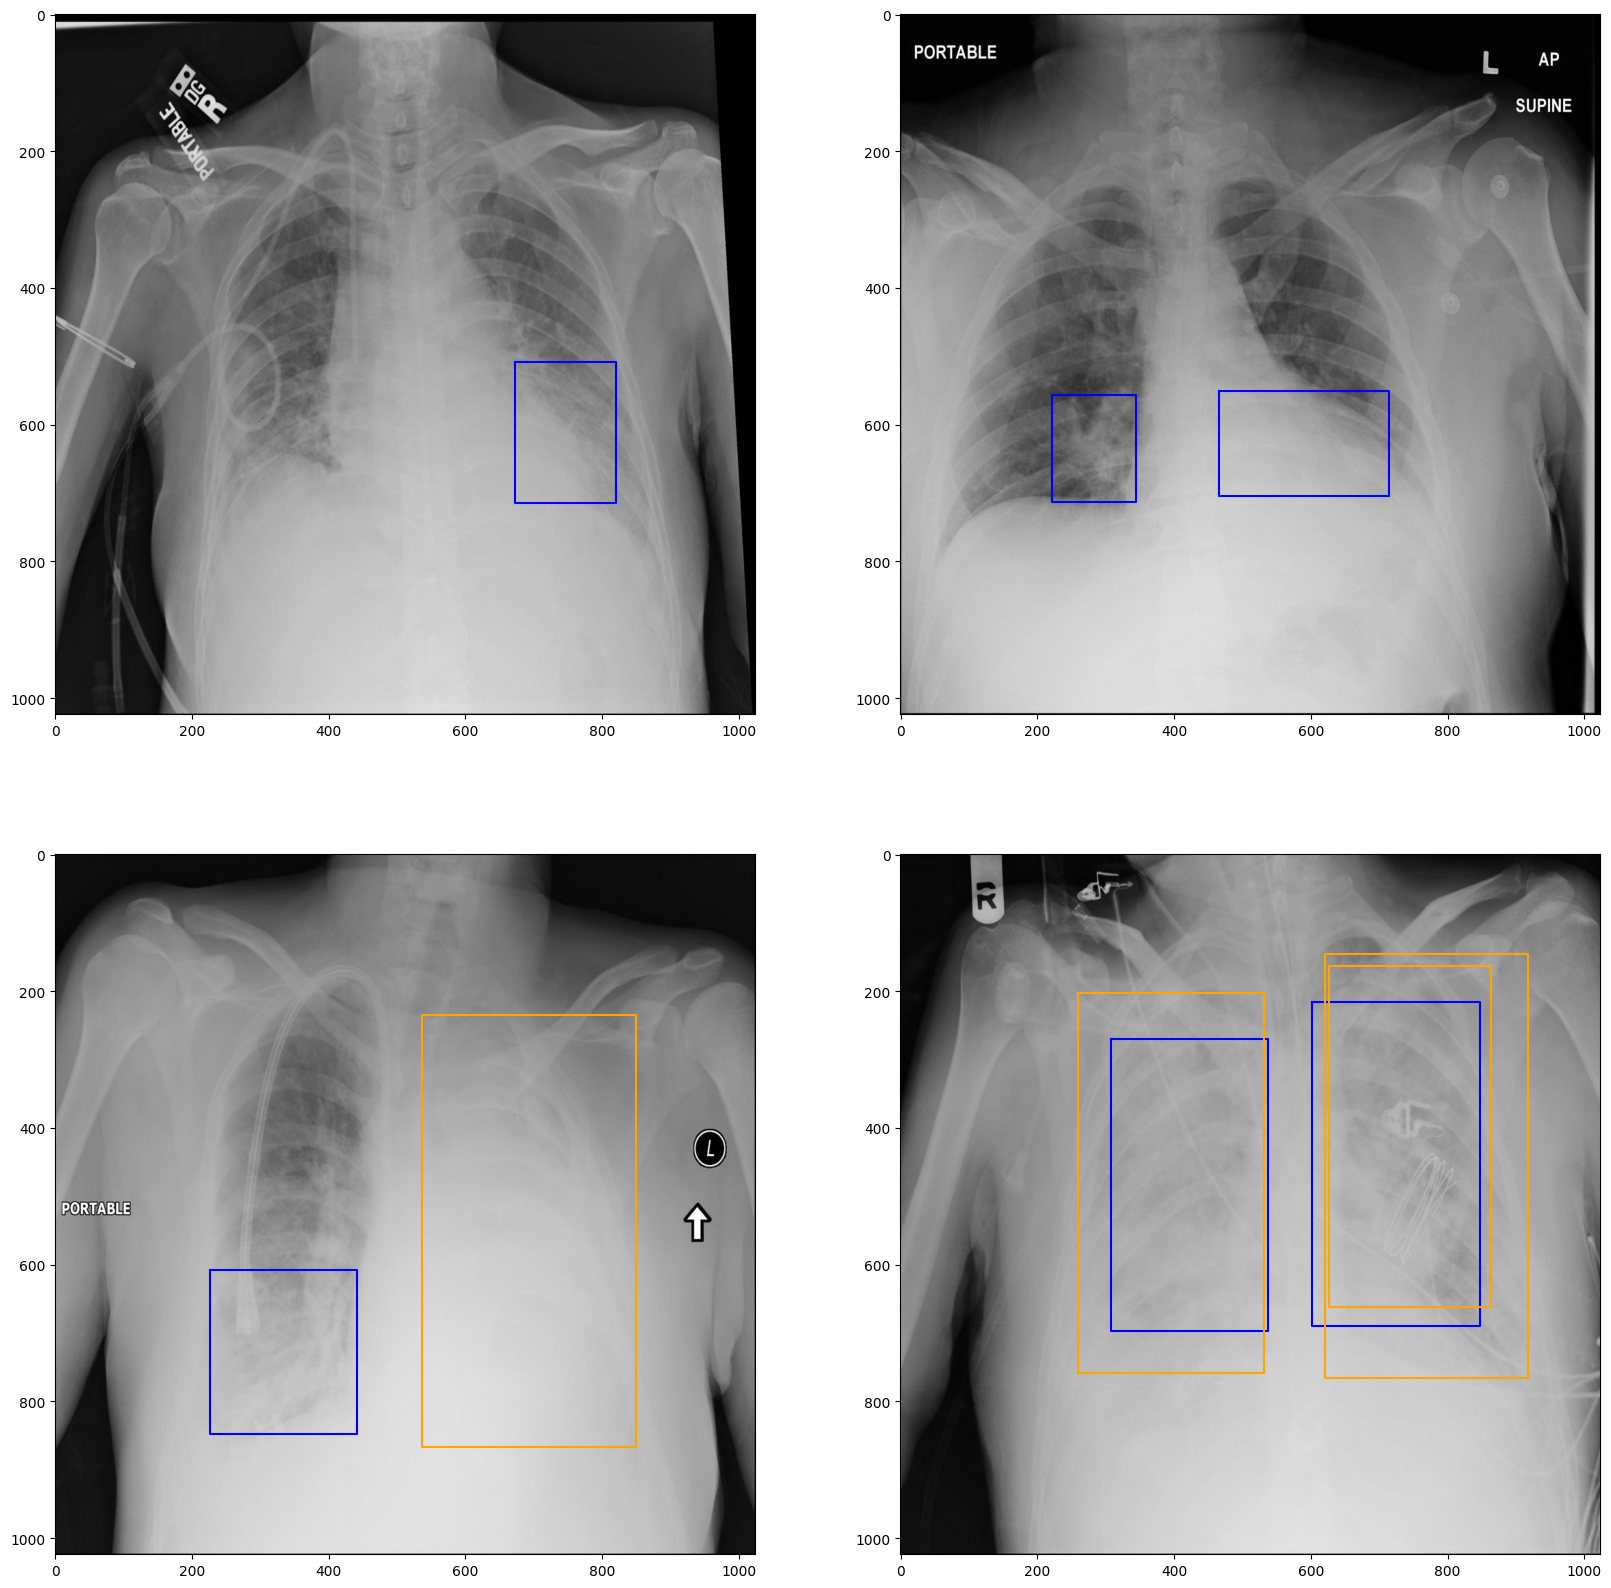

In [ ]:
plot_examples(val_series, 2, 2, 'val')

In [ ]:
results = model(TEST_IMG_DIR, verbose=False, conf=0.28) # conf=0.26 gives better score on private


WARNING ⚠️ inference results will accumulate in RAM unless `stream=True` is passed, causing potential out-of-memory
errors for large sources or long-running streams and videos. See https://docs.ultralytics.com/modes/predict/ for help.

Example:
    results = model(source=..., stream=True)  # generator of Results objects
    for r in results:
        boxes = r.boxes  # Boxes object for bbox outputs
        masks = r.masks  # Masks object for segment masks outputs
        probs = r.probs  # Class probabilities for classification outputs



In [ ]:
def get_id_from_path(path):
    return os.path.splitext(os.path.basename(path))[0]

print(get_id_from_path(results[1].path))
print(results[1].boxes.xywh)
print(results[1].boxes.conf)

0005d3cc-3c3f-40b9-93c3-46231c3eb813
tensor([], device='cuda:0', size=(0, 4))
tensor([], device='cuda:0')


In [ ]:
with open('/content/drive/MyDrive/Dataset/submission.csv', 'w') as file:
    file.write("patientId,PredictionString\n")

    for result in tqdm(results):
        line = get_id_from_path(result.path) + ','

        for conf, xywh in zip(result.boxes.conf, result.boxes.xywh):
            x, y, w, h = xywh
            line += f"{conf:.2f} {x-w/2:.2f} {y-h/2:.2f} {w:.2f} {h:.2f} "

        line = line.strip()
        file.write(line+"\n")

100%|██████████| 3000/3000 [00:00<00:00, 4496.10it/s]


In [ ]:
path = Path('/content/drive/MyDrive/Dataset/submission.csv')
df = pd.read_csv(path)
print(path.name)

df['pred_count'] = df['PredictionString'].apply(lambda x: 0 if pd.isna(x) else int(len(x.split()) / 5))
df['pred_count'].value_counts().sort_index()

submission.csv


pred_count
0    2440
1     343
2     192
3      21
4       4
Name: count, dtype: int64

In [ ]:
def str_to_boxes(s: str) -> list:  # return c,x,y,w,h
    if pd.isna(s) or len(s) == 0:
        return []

    boxes = []
    n = len(s.split()) // 5
    for i in range(n):
        box = s.split()[i * 5:i * 5 + 5]
        boxes.append(list(map(float, box)))

    return boxes

def remove_empty_boxes(s: str) -> str:
    if pd.isna(s) or len(s) == 0:
        return s

    n = len(s.split()) // 5
    data = s.split()
    for i in range(n):
        box = data[i * 5:i * 5 + 5]
        if float(box[2]) * float(box[3]) == 0:
            s = s.replace(' '.join(map(str, box)), '').strip()

    return s

In [ ]:
df['PredictionString'] = df['PredictionString'].apply(remove_empty_boxes)

In [ ]:
def box_areas_utils(box1, box2):  # corner coords
    _, left_x1, left_y1, w1, h1 = box1
    _, left_x2, left_y2, w2, h2 = box2

    assert w1 * h1 * w2 * h2 > 0, 'w or h is 0'

    right_x1, right_x2 = left_x1 + w1, left_x2 + w2
    top_y1, top_y2 = left_y1 + h1, left_y2 + h2

    area1, area2 = w1 * h1, w2 * h2
    right_xi = min(right_x1, right_x2)
    left_xi = max(left_x1, left_x2)
    top_yi = min(top_y1, top_y2)
    bottom_yi = max(left_y1, left_y2)

    if right_xi <= left_xi or top_yi <= bottom_yi:
        intersection = 0
    else:
        intersection = (right_xi - left_xi) * (top_yi - bottom_yi)

    union = area1 + area2 - intersection
    return area1, area2, intersection, union


def iou(box1, box2):
    area1, area2, intersection, union = box_areas_utils(box1, box2)
    return intersection / union


def two_boxes_overlap(box1, box2) -> bool:
    return iou(box1, box2) > 0.3


def one_box_inside_another(box1, box2) -> bool:
    area1, area2, intersection, union = box_areas_utils(box1, box2)
    return intersection / area1 > 0.7 or intersection / area2 > 0.7


def merge_boxes(box1, box2):
    c1, x1, y1, w1, h1 = box1
    c2, x2, y2, w2, h2 = box2
    min_x, min_y = min([x1, x2]), min([y1, y2])
    max_x, max_y = max([x1 + w1, x2 + w2]), max([y1 + h1, y2 + h2])

    w, h = max_x - min_x, max_y - min_y
    # reduce w, h by 10%
    dw, dh = w * 0.05, h * 0.05
    w, h = w * 0.9, h * 0.9

    return (c1 + c2) / 2, (x1 + x2) / 2, (y1 + y2) / 2, (w1+w2) / 2, (h1+h2) / 2


def detect_overlapping(s: str, type='both') -> bool:
    if pd.isna(s):
        return False

    n = len(s.split()) // 5
    for i in range(n):
        box1 = list(map(float, s.split()[i * 5:i * 5 + 5]))
        for j in range(n):
            if i == j:
                continue
            box2 = list(map(float, s.split()[j * 5:j * 5 + 5]))

            if type == 'both':
                if two_boxes_overlap(box1, box2) or one_box_inside_another(box1, box2):
                    return True
            elif type == 'overlap':
                if two_boxes_overlap(box1, box2) and not one_box_inside_another(box1, box2):
                    return True
            elif type == 'inside':
                if one_box_inside_another(box1, box2):
                    return True

    return False


def merge_overlapping(s: str) -> str:
    if pd.isna(s):
        return s

    boxes = str_to_boxes(s)

    for i in range(len(boxes)):
        for j in range(i + 1, len(boxes)):
            if boxes[i] is None or boxes[j] is None:
                continue
            if two_boxes_overlap(boxes[i], boxes[j]) or \
                    one_box_inside_another(boxes[i], boxes[j]):
                boxes[i] = merge_boxes(boxes[i], boxes[j])
                boxes[j] = None

    return ' '.join([' '.join(map(str, c)) for c in boxes if c is not None]).strip()

In [ ]:
df['overlaps'] = df['PredictionString'].apply(lambda s: detect_overlapping(s, type='overlap'));
df['inside_box'] = df['PredictionString'].apply(lambda s: detect_overlapping(s, type='inside'));
print(df.query('pred_count>0')['overlaps'].value_counts())
print(df.query('pred_count>0')['inside_box'].value_counts())

overlaps
False    560
Name: count, dtype: int64
inside_box
False    515
True      45
Name: count, dtype: int64


In [ ]:
df[df['overlaps']]['pred_count'].value_counts().sort_index()

Series([], Name: count, dtype: int64)

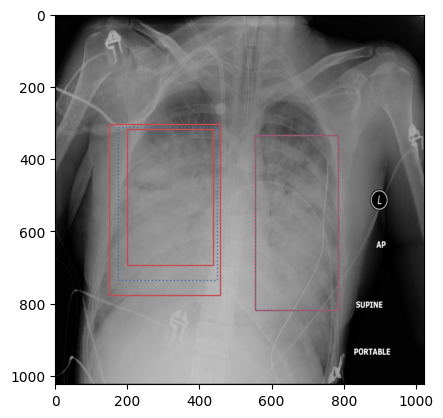

In [ ]:
df['PredictionString_'] = df['PredictionString']

s = df.query('inside_box').sample(1).iloc[0]

img = Image.open(f'/content/drive/MyDrive/Dataset/test_images/{s["patientId"]}.jpg')
img = img.convert('RGB')
ax = plt.gca()
boxes = str_to_boxes(s['PredictionString_'])
for b in boxes:
    rect = patches.Rectangle((b[1], b[2]), b[3], b[4], linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

fixed_s = merge_overlapping(s['PredictionString_'])
boxes_fixed = str_to_boxes(fixed_s)
for b in boxes_fixed:
    rect = patches.Rectangle((b[1], b[2]), b[3], b[4], linewidth=1, edgecolor='b', facecolor='none', linestyle=':')
    ax.add_patch(rect)
plt.imshow(img);

In [ ]:
df['PredictionString'] = df['PredictionString'].apply(merge_overlapping)

In [ ]:
df[['patientId', 'PredictionString']].to_csv(path.name, index=False)

In [ ]:
df.head(10)

patientId                  PredictionString  \
0  0000a175-0e68-4ca4-b1af-167204a7e0bc                               NaN   
1  0005d3cc-3c3f-40b9-93c3-46231c3eb813                               NaN   
2  000686d7-f4fc-448d-97a0-44fa9c5d3aa6                               NaN   
3  000e3a7d-c0ca-4349-bb26-5af2d8993c3d                               NaN   
4  00100a24-854d-423d-a092-edcf6179e061  0.31 531.18 382.22 255.23 472.64   
5  0015597f-2d69-4bc7-b642-5b5e01534676                               NaN   
6  001b0c51-c7b3-45c1-9c17-fa7594cab96e                               NaN   
7  0022bb50-bf6c-4185-843e-403a9cc1ea80                               NaN   
8  00271e8e-aea8-4f0a-8a34-3025831f1079                               NaN   
9  0028450f-5b8e-4695-9416-8340b6f686b0                               NaN   

   pred_count  overlaps  inside_box                 PredictionString_  
0           0     False       False                               NaN  
1           0     False       False                               NaN  
2           0     False       False                               NaN  
3           0     False       False                               NaN  
4           1     False       False  0.31 531.18 382.22 255.23 472.64  
5           0     False       False                               NaN  
6           0     False       False                               NaN  
7           0     False       False                               NaN  
8           0     False       False                               NaN  
9           0     False       False                               NaN